<img align="left" style="padding-right:10px;" src="./images/logo_dataiku.jpg">
<p>
    **<font color='#D2691E'size="5">US Census dataset (1/2) : Data exploration and classification on the train perimeter</font>**.
</p>

<p>
    This notebook contains :
</p>
<p>
    - <b>I)</b> The details of the preprocessing steps around the dataset (ONLY on the TRAIN dataset ("census_income_learn.csv")).
</p>
<p>
    - <b>II)</b> An exploration of its data.
</p>
<p>
    --> Continuous columns.
</p><p>
    --> Categorical columns.
</p>
<p>
    - <b>III)</b> 3 classifiers implementations : logistic regression, support vector classifier and random forest.
</p>
<p>
    --> Data which allowed to fit all those classifiers have been splitted between train and tests perimeter.
</p><p>
    --> A standard data scaler have been fitted only by the train data in order to avoid data leakage.
</p><p>
    -----> Test data is scaled thanks to the data scaler fitted with the train data.
</p><p>
    --> Dataset dimension have been reduced thanks to a Principal Component Analyzis.
</p><p>
    -----> Similarly, a PCA() object is instantiated, fitted with the train data, and then applied to the test data
</p>

<p>
    - <b>IV)</b> A benchmark of the 3 classifier performances.
</p>

<p>
    <center>
        **<font color='	#D2691E'size="6">PLAN</font>**
    </center>
</p>

<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>
<p>
        **<font color='#D2691E'size="4">I) Metadata definition</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II) Attributes analysis</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.1) Continuous columns analysis</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II.2) Categorical columns analysis</font>**
</p>
<p>
        **<font color='#D2691E'size="4">III) Categorical columns vectorization</font>**
</p>
<p>
        **<font color='#D2691E'size="4">IV) Separation into target and predictors</font>**
</p>
<p>
        **<font color='#D2691E'size="4">V) Separation into train and test perimeters</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VI) Dimension reduction</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII) Building classifiers with cross validation </font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.1) Logistic regression</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.1.A) Logistic regression : cross validation</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.1.B) Logistic regression : final model</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.2) Support vector classifier</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.2.A) Support vector classifier : cross validation</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.2.B) Support vector classifier : final model</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.3) Random forest</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.3.A) Random forest : cross validation</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII.3.B) Random forest : final model</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VIII) Benchmark of the classifier performances </font>**
</p>

<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import time
import random

c:\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class Bamboos():
    import numpy as np
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.orig_columns = list(self.dataframe.columns)
        self.n_orig_rows = dataframe.shape[0]
        self.n_orig_cols = dataframe.shape[1]
        self.cols = list(dataframe.columns)
        self.new_cols = []
        self.deleted_cols = []
        self.n_rows = None
        self.n_cols = None
        self.step_id = 0
        self.step_label = 'init'
        
        self.possible_keys = []
        
        #self.df_datatypes = pd.DataFrame(columns = ['step_id', 'step_label', 'column', 'datatype'])
        self.cols_caracs = pd.DataFrame(columns = ['step_id', 'step_label', 'col', 'col_datatype', 'completion_ratio', 'unique_ratio'])
        
        self.orig_cols_caracs = self.get_cols_caracs()
        self.orig_incomplete_cols = self.get_incomplete_cols()
        
        self.L_metadata_labels = ['step_id', 'step_label', 'global_completion_ratio',
                                  'incomplete_cols_ratio' ,'n_rows', 'n_cols', 'cols',
                                  'n_incomplete_cols', 'incomplete_cols', 'n_new_cols',
                                  'new_cols', 'n_deleted_cols','deleted_cols']
        self.metadata_buffer = pd.DataFrame(columns=self.L_metadata_labels)
        self.metadata_buffer = self.update_metadata_buffer(dataframe)
        
        
    def get_cols_caracs(self, arg='last'):
        dict_col_caracs = {}
        dataframe_length = len(self.dataframe)
        
        if len(self.dataframe)>0:
            for col in self.dataframe.columns:
                dict_col_caracs[col] = {}
                col_datatype = str(self.dataframe[col].dtype)
                dict_col_caracs[col]['step_id'] = self.step_id
                dict_col_caracs[col]['step_label'] = self.step_label
                dict_col_caracs[col]['col'] = col
                dict_col_caracs[col]['col_datatype'] = col_datatype
                                
                completion_ratio = len(self.dataframe[col][~self.dataframe[col].isnull()])/dataframe_length
                unique_ratio = len(np.unique(list(self.dataframe[col])))/dataframe_length
                dict_col_caracs[col]['completion_ratio'] = completion_ratio
                dict_col_caracs[col]['unique_ratio'] = unique_ratio
                dict_col_caracs[col]['step_label'] = self.step_label
                if unique_ratio == 1.0:
                    self.possible_keys.append(col)
            
            self.cols_caracs = self.cols_caracs.append(pd.DataFrame(dict_col_caracs).T)
            self.cols_caracs.drop_duplicates(subset=['step_id', 'col'], inplace=True)
            self.cols_caracs = self.cols_caracs[['step_id', 'step_label', 'col_datatype', 'completion_ratio', 'unique_ratio']]
            if arg == 'last':
                last_cols_caracs = self.cols_caracs[self.cols_caracs['step_id']==np.max(self.cols_caracs['step_id'])]
                return last_cols_caracs
            else:
                return self.cols_caracs
        else:
            return 'empty df !'
    
    def get_incomplete_cols(self):
        df_incomplete_cols = self.cols_caracs[(self.cols_caracs['completion_ratio']<1.0)&(self.cols_caracs['step_label']==self.step_label)]        
        df_incomplete_cols.sort_values(by='completion_ratio', ascending=False, inplace=True)
        self.incomplete_cols = list(df_incomplete_cols.index)
        self.n_incomplete_cols = len(self.incomplete_cols)
        return self.incomplete_cols
    
    def flag_one_step(self, flag_label, dataframe):
        print("flagging : %s"%flag_label)
        self.step_id+=1
        self.step_label = flag_label
        #self.get_cols_caracs()
        self.update_metadata_buffer(dataframe)
    
    def update_metadata_buffer(self, dataframe):
        self.new_cols = [col for col in dataframe.columns if not col in self.cols]
        self.n_new_cols = len(self.new_cols)
        self.deleted_cols = [col for col in self.cols if not col in dataframe.columns]
        self.n_deleted_cols = len(self.deleted_cols)
        self.dataframe = dataframe
        self.get_cols_caracs()
        self.get_incomplete_cols()
        self.cols = list(self.dataframe.columns)
        self.n_rows = dataframe.shape[0]
        self.n_cols = dataframe.shape[1]
        self.global_completion_ratio = np.sum(self.cols_caracs['completion_ratio'])/len(self.cols_caracs['completion_ratio'])
        self.incomplete_cols_ratio = len(set(self.incomplete_cols).intersection(set(self.cols)))/len(self.cols)
        self.L_metadata_values = [self.step_id, self.step_label, self.global_completion_ratio,
                                  self.incomplete_cols_ratio, self.n_rows, self.n_cols, self.cols,
                                  self.n_incomplete_cols, self.incomplete_cols, self.n_new_cols, 
                                  self.new_cols, self.n_deleted_cols, self.deleted_cols]
        dict_metadata_buffer = {label:value for label,value in zip(self.L_metadata_labels, self.L_metadata_values)}
        self.metadata_buffer = self.metadata_buffer.append(dict_metadata_buffer, ignore_index=True)
        
        cols_with_list_type = ['cols', 'incomplete_cols', 'new_cols', 'deleted_cols']
        for col in cols_with_list_type:
            self.metadata_buffer[col] = self.metadata_buffer[col].astype(str)
            
        self.metadata_buffer.drop_duplicates(inplace=True)
        self.metadata_buffer.sort_values(by='step_id', ascending=False, inplace=True)
        
        for col in cols_with_list_type:
            self.metadata_buffer = self.convert_in_list(self.metadata_buffer, col)
        return self.metadata_buffer
    
    def get_metadata_buffer(self):
        return self.metadata_buffer
    
    
    def get_steps(self):
        if len(self.dataframe)>0 :
            return self.cols_caracs[['step_id', 'step_label']].drop_duplicates()
        else:
            return 'empty df !'
    

    def sorted_columns(self, reverse = False):
        sorted_cols = sorted(list(self.dataframe.columns), reverse=reverse)
        return sorted_cols
    
    def sorted_columns_from_keys(self, list_of_keys):
        sorted_cols = list_of_keys
        for col in self.dataframe.columns:
            if not col in sorted_cols:
                sorted_cols.append(col)
        return sorted_cols
    
    def convert_in_list(self, dataframe, col):
        from ast import literal_eval
        """
        This function goal is to convert a pandas column into a "list" datatype column
        IMPORTANT : The column values must match with the python lists pattern in order to be read and converted correctly.

        RESULT : The same column, with each value converted into an array : that's also possible to loop over the array values

        PARAMS :
        - dataframe : the entry DataFrame
        - col : String, the column to convert
        """
        dataframe[col] = dataframe[col].apply(literal_eval)
        return dataframe

In [3]:
df_metadatas = pd.read_csv('columns_metadatas.csv', sep=';')
L_data_schema = list(df_metadatas['column_name'])
df_metadatas.head(10)

,column_name,datatype
0,age,continuous
1,class_of_worker,nominal
2,detailed_industry_recode,nominal
3,detailed_occupation_recode,nominal
4,education,nominal
5,wage_per_hour,continuous
6,enroll_in_edu_inst_last_wk,nominal
7,marital_stat,nominal
8,major_industry_code,nominal
9,major_occupation_code,nominal


In [4]:
df_train = pd.read_csv('census_income_learn.csv', names=L_data_schema)
df_train.head(10)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [5]:
df_train.shape

(199523, 42)

<p>
        **<font color='#D2691E'size="4">I) Metadata definition</font>**
</p>

In [6]:
bamboos = Bamboos(df_train)
cols_caracs = bamboos.get_cols_caracs()
cols_caracs

c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,step_id,step_label,col_datatype,completion_ratio,unique_ratio
age,0,init,int64,1,0.000456088
age,0,init,int64,1,0.000456088
capital_gains,0,init,int64,1,0.000661578
capital_losses,0,init,int64,1,0.000566351
citizenship,0,init,object,1,2.50598e-05
class_of_worker,0,init,object,1,4.51076e-05
country_of_birth_father,0,init,object,1,0.000215514
country_of_birth_mother,0,init,object,1,0.000215514
country_of_birth_self,0,init,object,1,0.000215514
detailed_household_and_family_stat,0,init,object,1,0.000190454


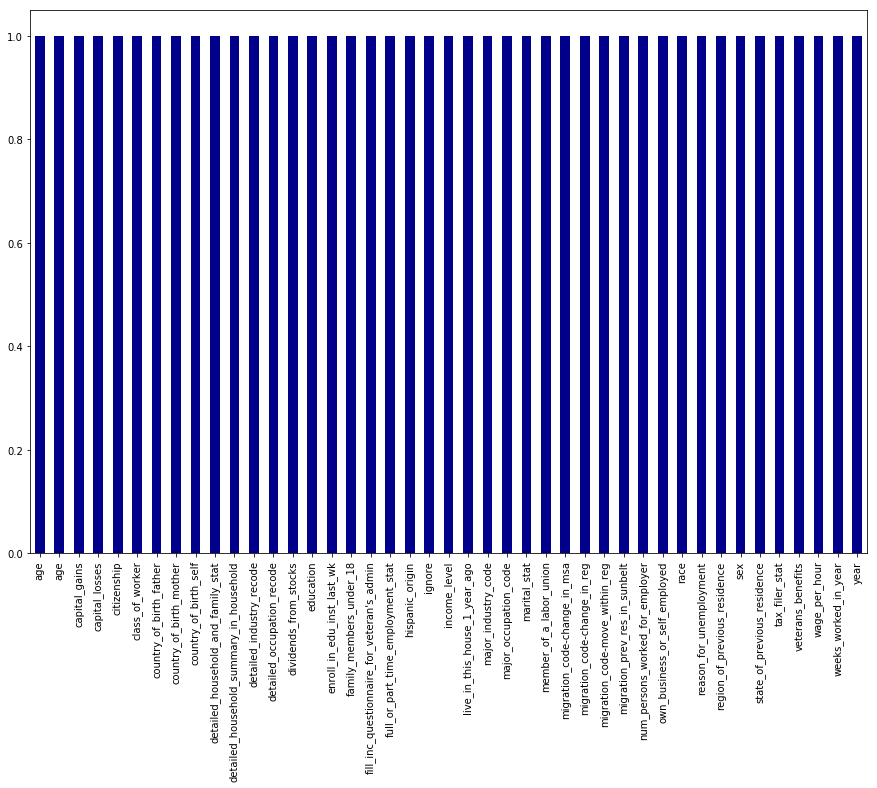

In [7]:
plt.figure(figsize=(15,10))
cols_caracs['completion_ratio'].plot.bar(color='darkblue')

In [8]:
df_metadatas = df_metadatas[df_metadatas['column_name']!='ignore']
df_train.drop('ignore', axis=1, inplace=True)

In [9]:
bamboos.flag_one_step('removing_column_ignore', df_train)

flagging : removing_column_ignore


c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
L_continuous_cols = list(df_metadatas['column_name'][df_metadatas['datatype']=='continuous'])
for col in L_continuous_cols : 
    df_train[col] = df_train[col].astype(float)
L_categorical_cols = list(df_metadatas['column_name'][df_metadatas['datatype']=='nominal'])
L_categorical_cols.remove('income_level')
for col in L_categorical_cols : 
    df_train[col] = df_train[col].astype(str)

In [11]:
bamboos.flag_one_step('affecting_correct_datatypes', df_train)
metadata_buffer = bamboos.metadata_buffer
metadata_buffer

flagging : affecting_correct_datatypes


c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
2,2,affecting_correct_datatypes,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
0,1,removing_column_ignore,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],1,[ignore]
1,0,init,1.0,0.0,199523,42,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]


<p>
        **<font color='#D2691E'size="4">II) Attributes analysis</font>**
</p>

<p>
        **<font color='#D2691E'size="4">II.1) Continuous columns analysis</font>**
</p>

In [12]:
L_continuous_cols

['age',
 'wage_per_hour',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

In [13]:
df_train_low = df_train[df_train['income_level']==' - 50000.']
df_train_high = df_train[df_train['income_level']==' 50000+.']

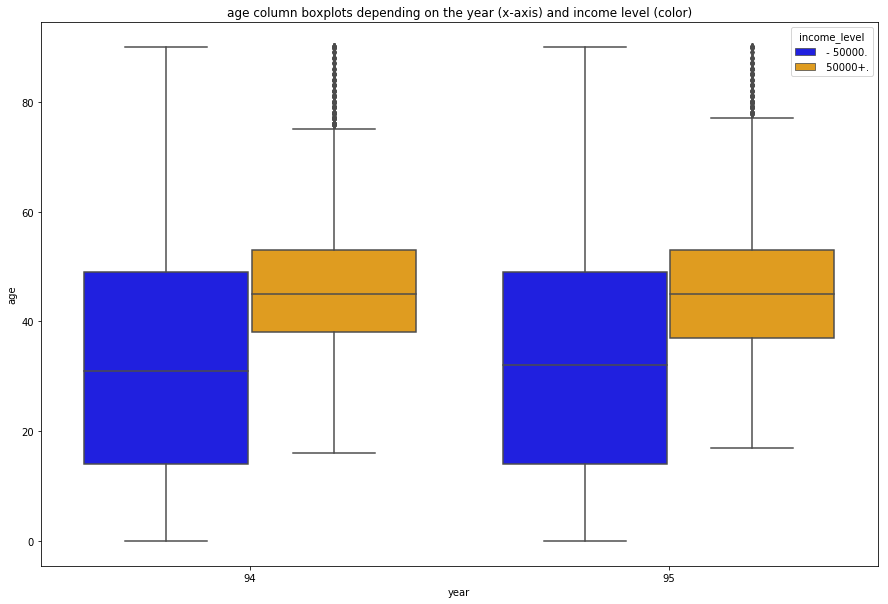

In [14]:
col = 'age'
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)
# People with the highest income_level are (in general) older than people with less income : most part of them is aged 
# between 30 and 55.
# In an other hand, the majority of people is between 16 and 50 for the other category.
# Below histograms will allow to analyze the ages more precisely.

Text(0.5,1,'Age histrogram for the lower income category')

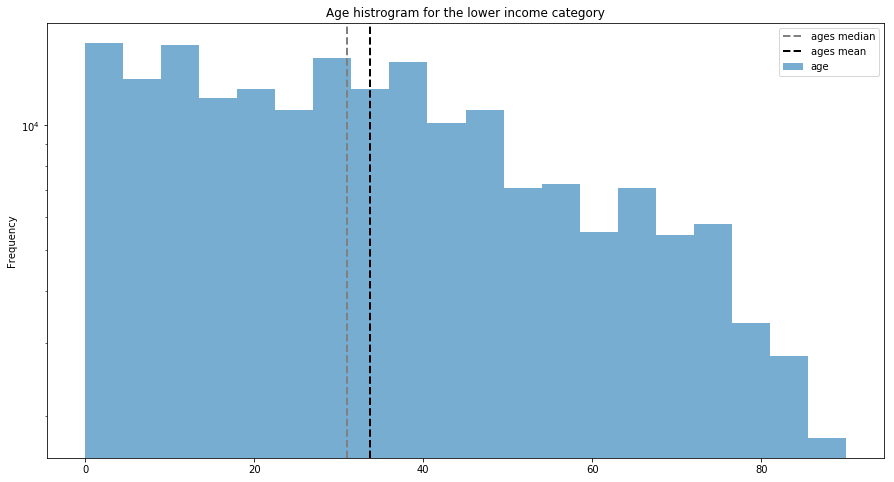

In [15]:
df_train_low[['age']].plot.hist(bins=20,figsize=(15,8),alpha=0.6,logy=True)
plt.axvline(df_train_low['age'].median(), color='grey', linestyle='--',linewidth=2,label='ages median')
plt.axvline(df_train_low['age'].mean(), color='black', linestyle='--',linewidth=2,label='ages mean')
plt.legend(loc='upper right')
plt.title("Age histrogram for the lower income category")
#The age groups in this category are mostly between 0 (which must be an eror; real minimal ages must be around 16) 
##and 50 years old

Text(0.5,1,'Age histrogram for the higher income category')

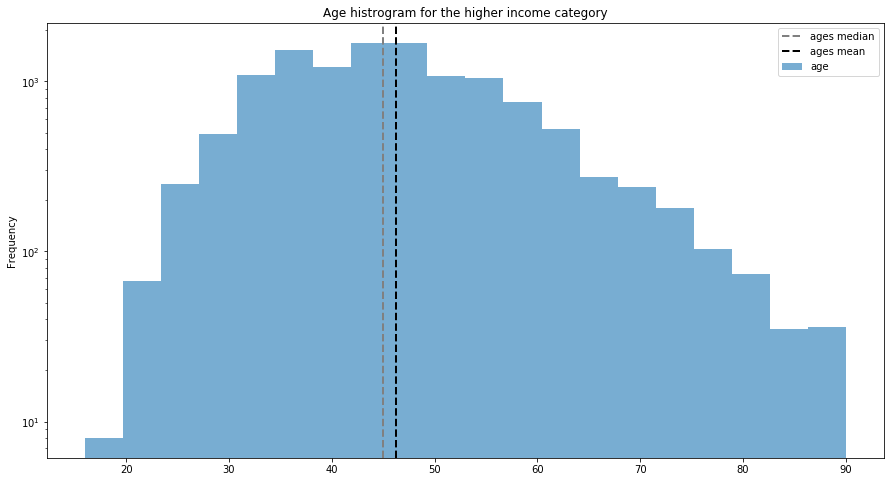

In [16]:
df_train_high[['age']].plot.hist(bins=20,figsize=(15,8),alpha=0.6,logy=True)
plt.axvline(df_train_high['age'].median(), color='grey', linestyle='--',linewidth=2,label='ages median')
plt.axvline(df_train_high['age'].mean(), color='black', linestyle='--',linewidth=2,label='ages mean')
plt.legend(loc='upper right')
plt.title("Age histrogram for the higher income category")
#The age groups in this category are mostly between 16 and 65 years old
#This population is (in median and in average) older than the previous one.

5.743263101084209 percent of people within the lower category have a positive wage_per_hour rate
4.490389274753674 percent of people within the upper category have a positive wage_per_hour rate


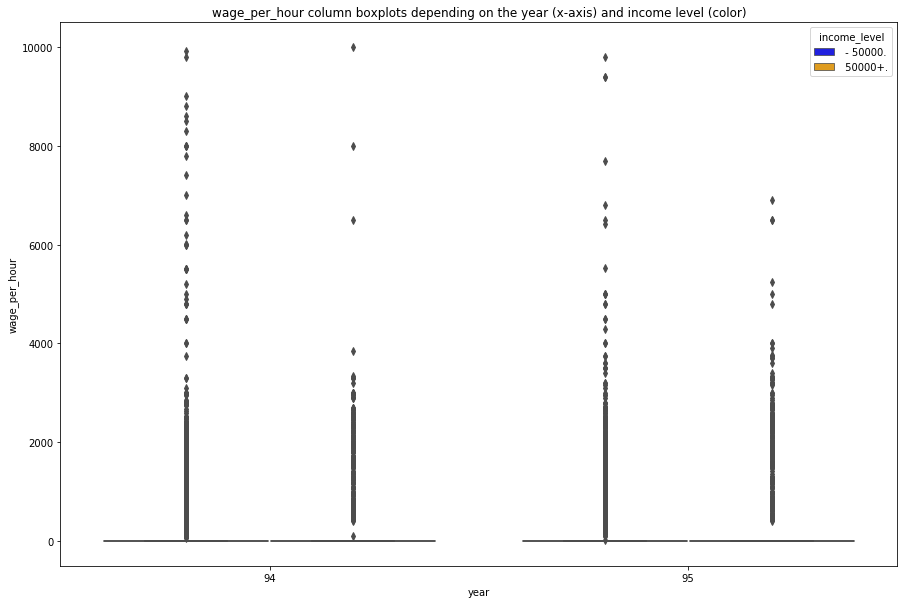

In [17]:
col = 'wage_per_hour'
plt.figure(figsize=(15,10))

percent_positive_low = 100*len(df_train_low[df_train_low['wage_per_hour']>0])/len(df_train_low)
percent_positive_high = 100*len(df_train_high[df_train_high['wage_per_hour']>0])/len(df_train_high)
print('%s percent of people within the lower category have a positive wage_per_hour rate'%percent_positive_low)
print('%s percent of people within the upper category have a positive wage_per_hour rate'%percent_positive_high)
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)
#That seems curious that values of this column are majorly "0.0" for both categories
#We can observe that many people outlies in the lowest catecory with very high values of wage_per_hour
#maybe this column is not well filled? 

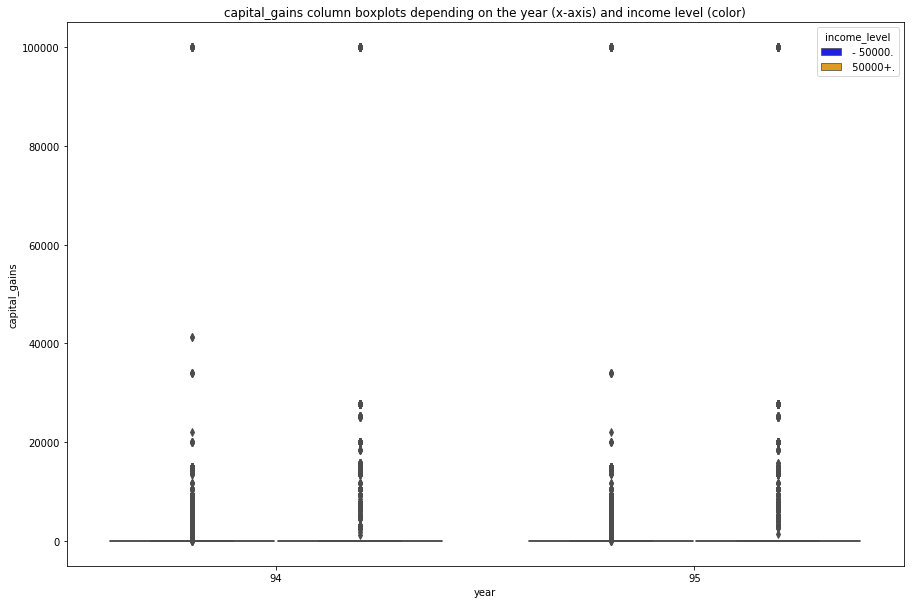

In [18]:
col = 'capital_gains'
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)

In [19]:
df_train['capital_gains'].quantile(0.95)

0.0

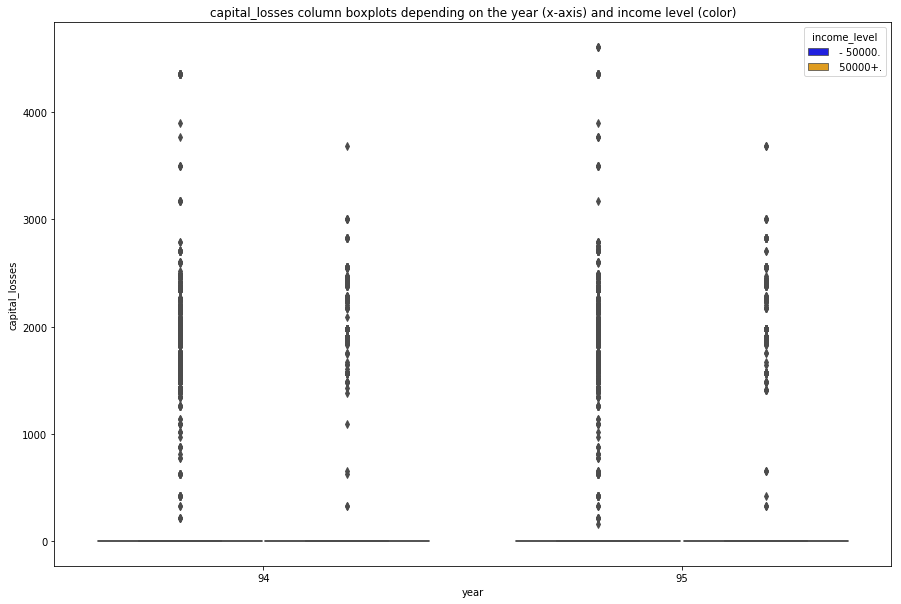

In [20]:
col = 'capital_losses'
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)

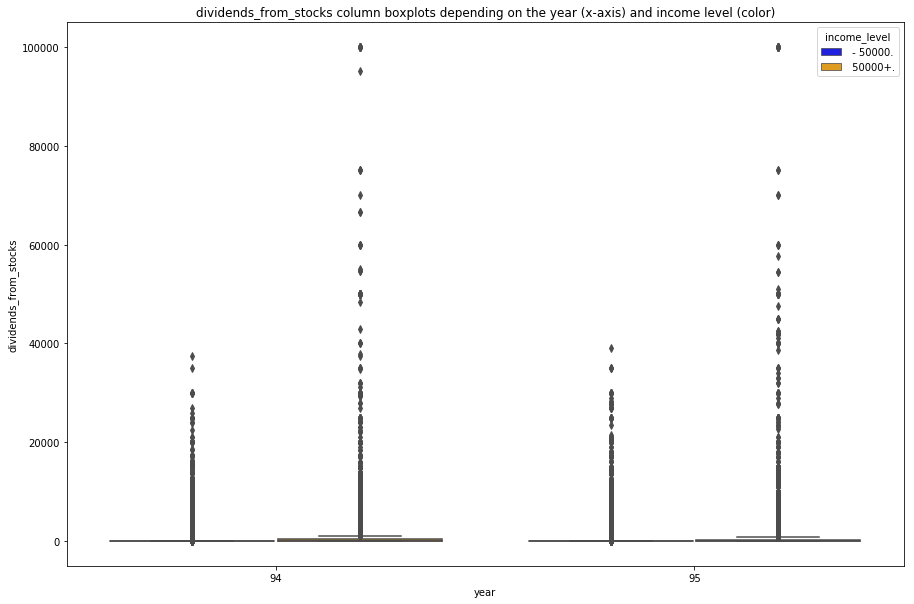

In [21]:
col = 'dividends_from_stocks'
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)

Income <50 000| num_persons_worked_for_employer's quantiles : {0.1: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 4.0, 0.9: 6.0}
Icome < 50 000| num_persons_worked_for_employer's average : 1.8207073810656136



Income >50 000| num_persons_worked_for_employer's quantiles : {0.1: 1.0, 0.25: 2.0, 0.5: 4.0, 0.75: 6.0, 0.9: 6.0}
Icome > 50 000| num_persons_worked_for_employer's average : 4.0037150702632855





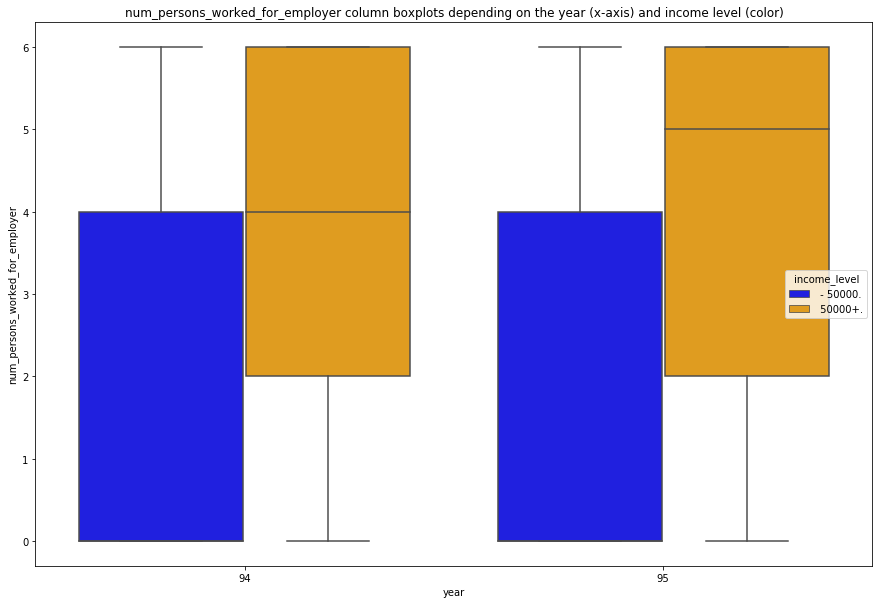

In [22]:
col = 'num_persons_worked_for_employer'
print("Income <50 000| %s's quantiles : %s"%(col,dict(df_train_low[col].quantile([0.1, 0.25, 0.5 , 0.75, 0.9]))))
print("Icome < 50 000| %s's average : %s"%(col, np.mean(df_train_low[col])))
print("\n\n")
print("Income >50 000| %s's quantiles : %s"%(col, dict(df_train_high[col].quantile([0.1, 0.25, 0.5 , 0.75, 0.9]))))
print("Icome > 50 000| %s's average : %s"%(col, np.mean(df_train_high[col])))
print("\n\n")
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)
# People with an income <50 000 ten to work in smaller companies than people with an income >50 000 :
# In effect, the number of persons which worked for their employer is, in average, 1.8 while its 4 for the other category.
# When we look at the median values, this trend is stronger since 50 percent of the lower income category were in companies
## with 0 employees (a value that we can interpret as "the person was a freelancer" or "the person was unemployed")
# In comparison, 50 percent of the higher income category worked in companies with at least 4 employees.

Income <50 000| weeks_worked_in_year's quantiles : {0.1: 0.0, 0.25: 0.0, 0.5: 0.0, 0.75: 52.0, 0.9: 52.0}
Icome < 50 000| weeks_worked_in_year's average : 21.527762489246076



Income >50 000| weeks_worked_in_year's quantiles : {0.1: 42.0, 0.25: 52.0, 0.5: 52.0, 0.75: 52.0, 0.9: 52.0}
Icome > 50 000| weeks_worked_in_year's average : 48.06961718623809





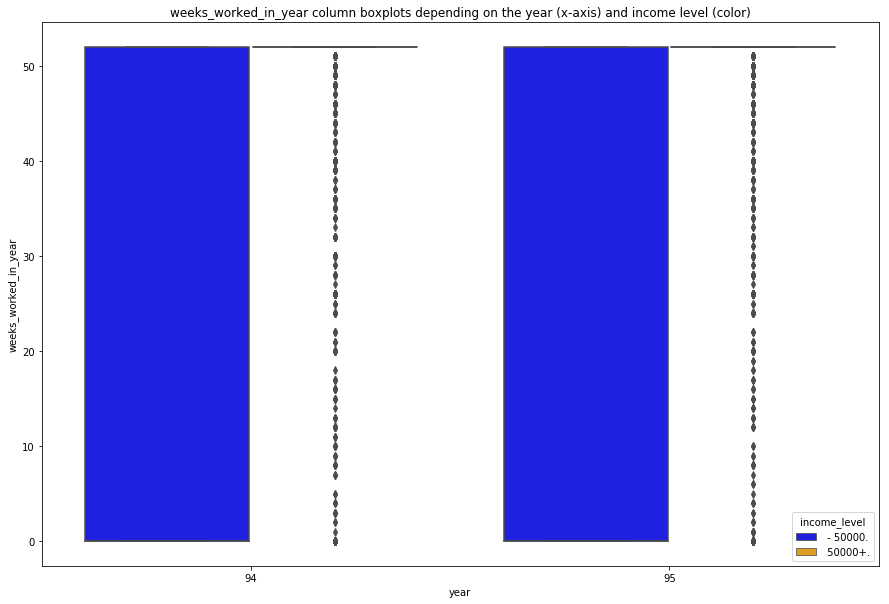

In [23]:
col = 'weeks_worked_in_year'
print("Income <50 000| %s's quantiles : %s"%(col,dict(df_train_low[col].quantile([0.1, 0.25, 0.5 , 0.75, 0.9]))))
print("Icome < 50 000| %s's average : %s"%(col, np.mean(df_train_low[col])))
print("\n\n")
print("Income >50 000| %s's quantiles : %s"%(col, dict(df_train_high[col].quantile([0.1, 0.25, 0.5 , 0.75, 0.9]))))
print("Icome > 50 000| %s's average : %s"%(col, np.mean(df_train_high[col])))
print("\n\n")
plt.figure(figsize=(15,10))
plt.title("%s column boxplots depending on the year (x-axis) and income level (color)"%col)
sns.boxplot(x="year", y=col,
            hue="income_level",
            palette=["blue", "orange"],
            data=df_train)
#The number of weeks worked in a given year can clearly helps to distinguish the two classes: 
#The lower income category members worked the less over years : They work, in average, less than 22 weeks per years .
# The higher income category members have, in general, full time contracts, since only 10 percent of them worked less than 42 weeks.

<p>
        **<font color='#D2691E'size="4">II.2) Categorical columns analysis</font>**
</p>

In [24]:
def group_by_frequency(myDataFrame,myColumn):
    import numpy as np
    """
    This function goal is to build an aggregated DataFrame which contains the occurences of the catagorical terms contained in
    'myColumn' args.

    RESULT : an aggregated DataFrame with the occurences of each values.
    - The DataFrame is sorted by descending occurences.
    - It also contains :
        - rank of each category in terms of occurences.
        - cumsum of occurences from the first value to the last one.
        - percent of total occurences covered by the upper categories at a given row.

    PARAMS :
    - 'myDataFrame' : the entry DataFrame
    - 'myColumn' : the column concerned by the frequencies count
    """
    grouped = myDataFrame.copy()
    grouped['occurences'] = 1
    grouped = grouped[[myColumn,'occurences']].groupby(myColumn).sum()
    grouped.sort_values(by='occurences', ascending=False, inplace=True)
    grouped['rank'] = range(1,len(grouped)+1)
    grouped['cumsum'] = np.cumsum(grouped['occurences'])
    grouped['percent_of_total'] = grouped['cumsum']/grouped['occurences'].sum()

    return grouped

In [25]:
df_focus = group_by_frequency(df_train, 'income_level')
df_focus

,occurences,rank,cumsum,percent_of_total
income_level,,,,
- 50000.,187141,1,187141,0.937942
50000+.,12382,2,199523,1.000000


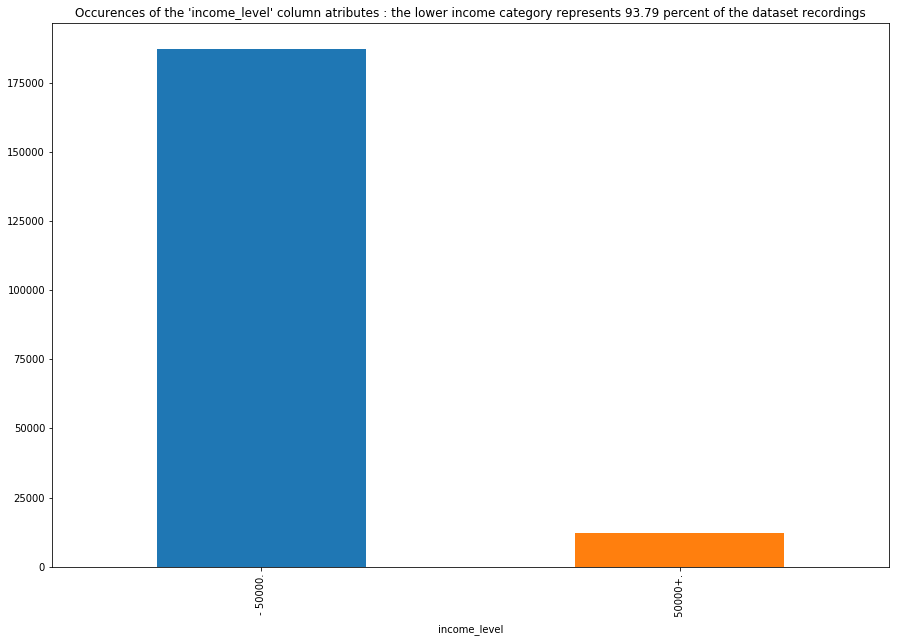

In [26]:
lower_income_weigth = 100*df_focus.loc[' - 50000.','percent_of_total']
title = "Occurences of the 'income_level' column atributes : the lower income category represents %.2f percent of the dataset recordings"%lower_income_weigth
df_focus['occurences'].plot.bar(figsize=(15,10), title=title)
plt.show()
#We can clearly see that a huge majority part (93.7%) of the dataset members are in the category of the "-50 000" income level
#Algorithms may have to be parametered in order to take this imbalance into account.

In [27]:
def group_by_income(myDataFrame, myColumn):
    aggregator_columns = ['income_level', myColumn]
    grouped = myDataFrame.copy()
    grouped['occurences'] = 1
    grouped = grouped[aggregator_columns+['occurences']].groupby(aggregator_columns).sum()
    grouped.reset_index(inplace=True)
    
    L_attributes = np.unique(grouped[myColumn])
    n_attributes = len(L_attributes)
    for attribute in L_attributes:
        for income_level in [' - 50000.', ' 50000+.']:
            check = attribute in list(grouped[myColumn][grouped['income_level']==income_level]) 
            if not check:
                grouped = grouped.append({'income_level':income_level, myColumn:attribute, 'occurences':0}, ignore_index=True)
            
    grouped.sort_values(by=['income_level', myColumn], ascending=True, inplace=True)
    
    return grouped

<p>
    <b>N.B 1:</b>  The following part will analyze categorical columns thanks to barplots. I wrote an analysis for each interesting plot. The analysis is displayed thanks to a file, 'graphics_descriptions.csv', which stores my text; so it's important to have this file if you execute the notebook.
</p>
<p>
    <b>N.B 2:</b> For performance reasons (the classifiers took more than a day to learn) I decided to remove some columns of the dataset : I explain why here. You will see later a list, "L_cols_to_drop" that contains the columns in question.
</p>

In [28]:
df_graphics_desciptions = pd.read_csv('graphics_descriptions.csv', sep=';')
df_graphics_desciptions.fillna('', inplace=True)
df_graphics_desciptions.head(10)

,column,analysis,conclusion
0,class_of_worker,A large part (50.24%) of all people worked in ...,
1,detailed_industry_recode,"The code ""0"" represents 50,46% of the recordin...",N.B : For performances needs (models took more...
2,detailed_occupation_recode,"The code ""0"" again represents 50,46% of the re...",
3,education,"""high school graduates"" captures 24.26% of the...",This statistics reinforce the fact that our po...
4,enroll_in_edu_inst_last_wk,Most of the global population (93.69%) did not...,
5,marital_stat,"43.34% of the global population were ""Never ma...",
6,major_industry_code,"The attribute ""Not in universe or children"" re...",
7,major_occupation_code,"The attribute ""Not in universe"" represents 50,...",People with the higher income are more qualifi...
8,race,83.88% of the global population is composed of...,Race may have an impact on the income.
9,hispanic_origin,,N.B : For performances needs (models took more...




Analysis : 
A large part (50.24%) of all people worked in undefined types of jobs.  36.1% of all people worked in the private sector, which is the sector which inclues the largest number of people with the higher incomes.


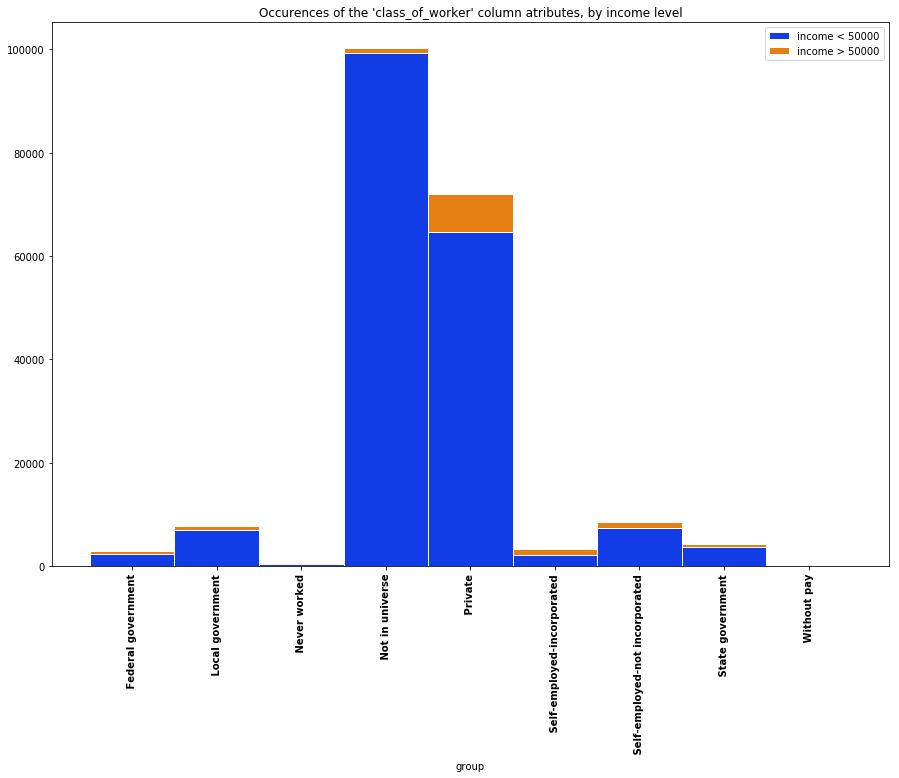



Analysis : 
The code "0" represents 50,46% of the recordings. Remaining codes are distributed over the other categories.

Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since it brings a lot of attributes in the model and don't seems to bring information that allows to discriminate the two categories.


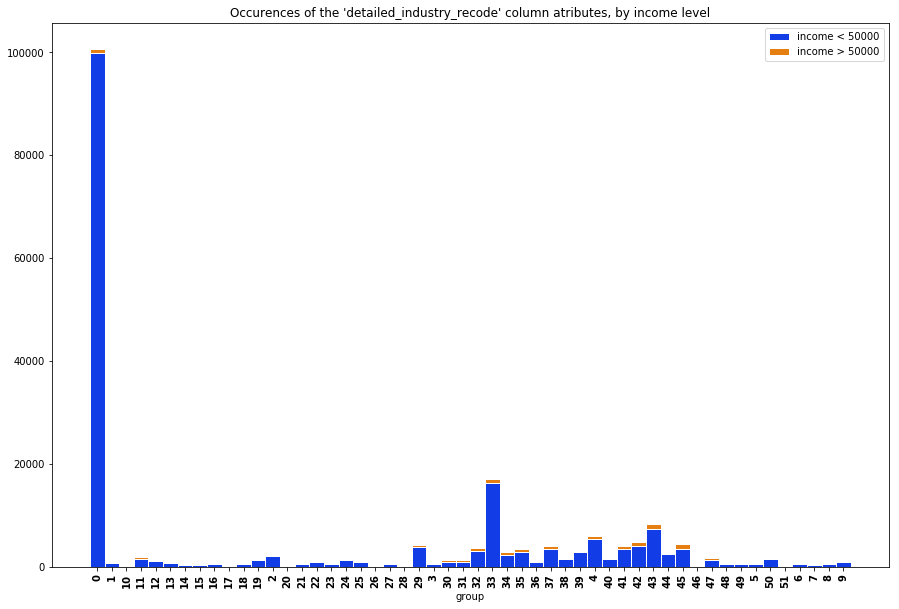



Analysis : 
The code "0" again represents 50,46% of the recordings. That is interesting to observe that the code "2" captures himself 7.31% of the higher income population (this is a huge percent since there are more than 40 categories). Remaining codes are distributed over the other categories.


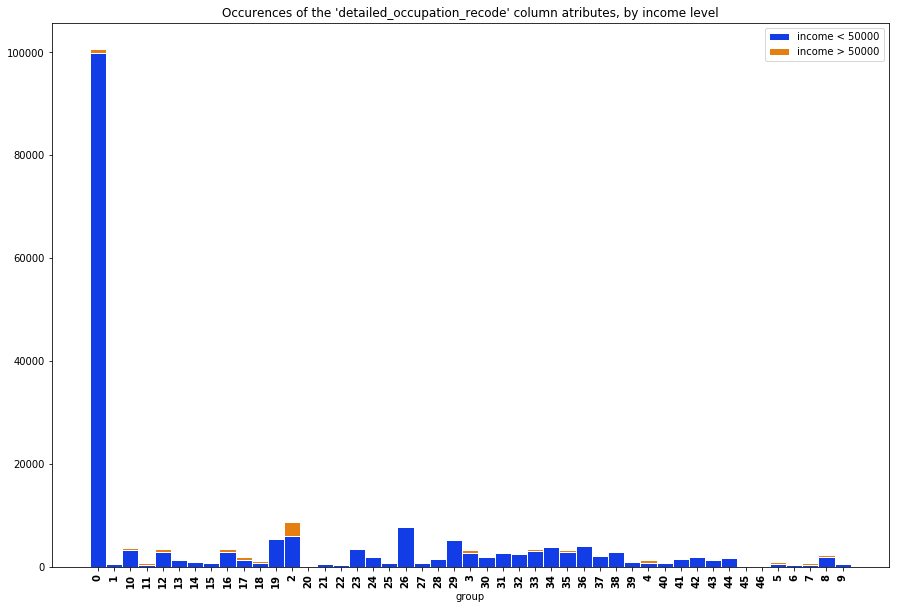



Analysis : 
"high school graduates" captures 24.26% of the population in terms of (highest) education. Next, "childrens", "Some college but no degree" and "Bachelors degree" respectively captures 23.76%, 13.94% and 9.95% of the population.

Conclusion : 
This statistics reinforce the fact that our population is majorly young. Furthermore, it is mid-graduated (in the sense that most people have an education under the master degree), or both young and mid-graduated. Finally, We find the major part of the higher income population in few categories (31.61%, 16.45% and 15.17%  of them have respectively a bachelor degree, a master degree, or a high school graduation. Education seems to have an impact on this population income since most of the highest incomes are graduated.


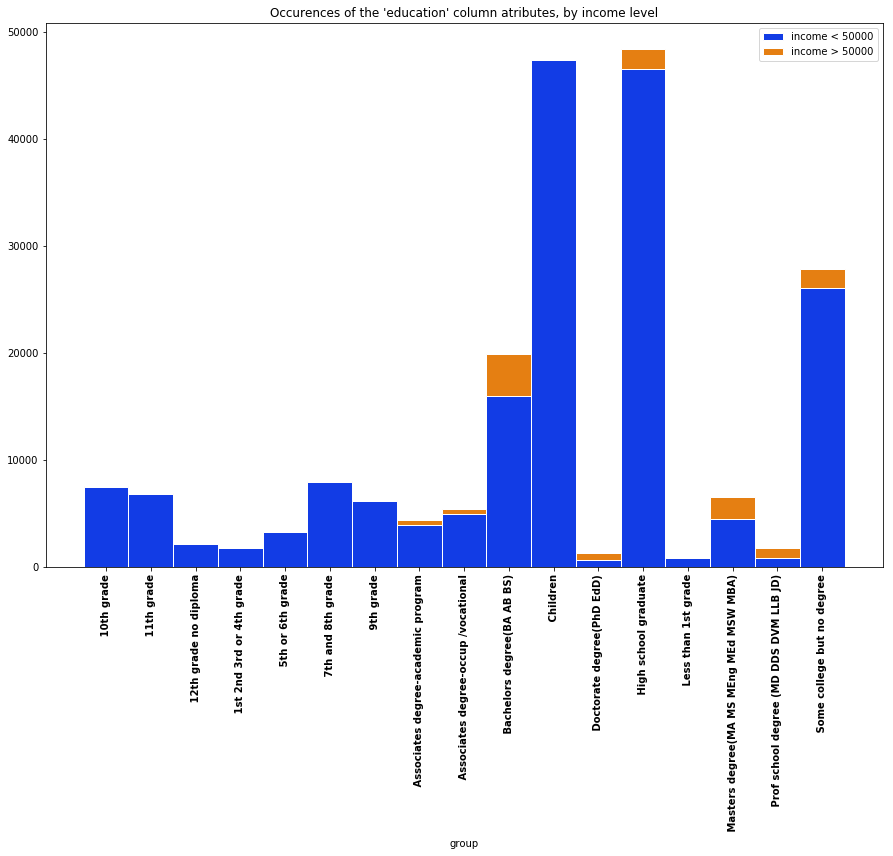



Analysis : 
Most of the global population (93.69%) did not enrolled in edu on its past week. 99.75% of the higher income population is in this case.


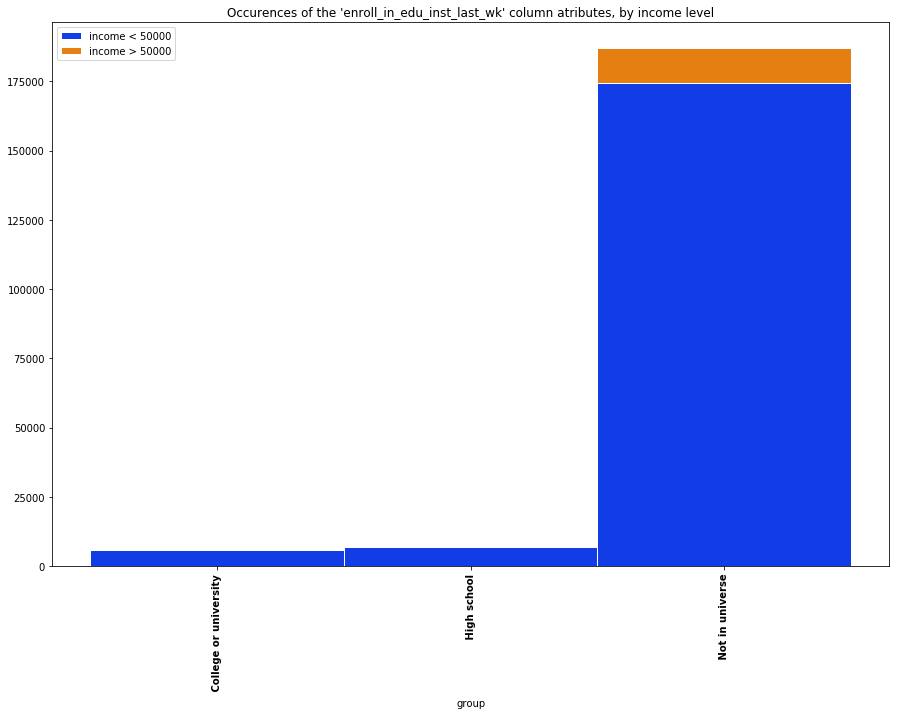



Analysis : 
43.34% of the global population were "Never married" but this category takes the major part of its weight thanks to the lower income population : 45.61% of them never married while only 9.02% of the higher income population's members are in this case (We could suppose that this population is older). 42.21% of the global population  has the status "Married-civilian spouse present".


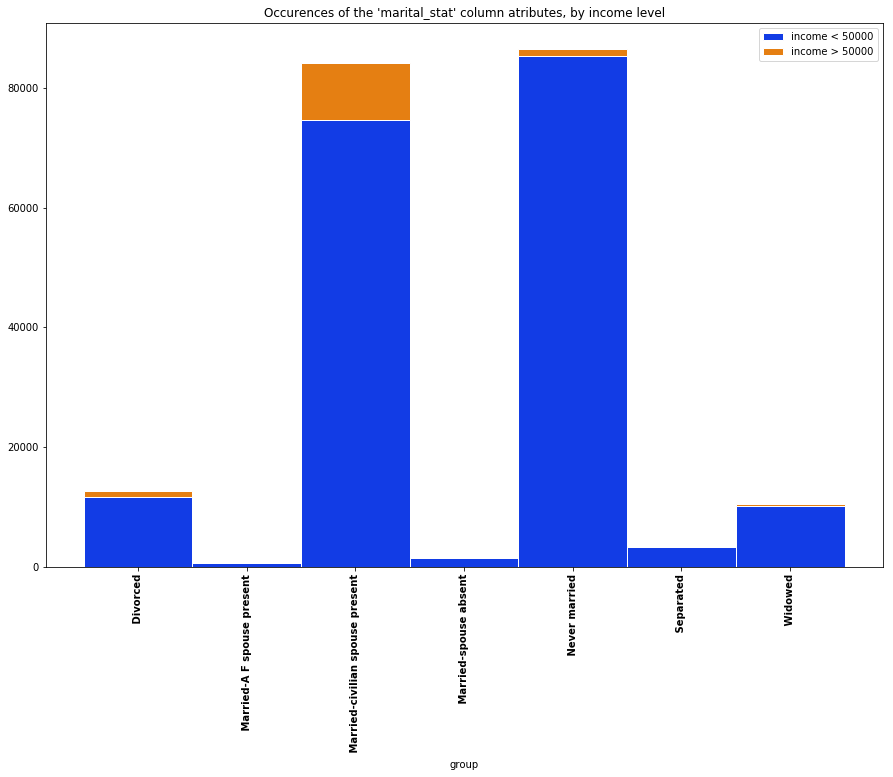



Analysis : 
The attribute "Not in universe or children" represents 50,46% of the recordings. Remaining attributes are distributed over the other categories.


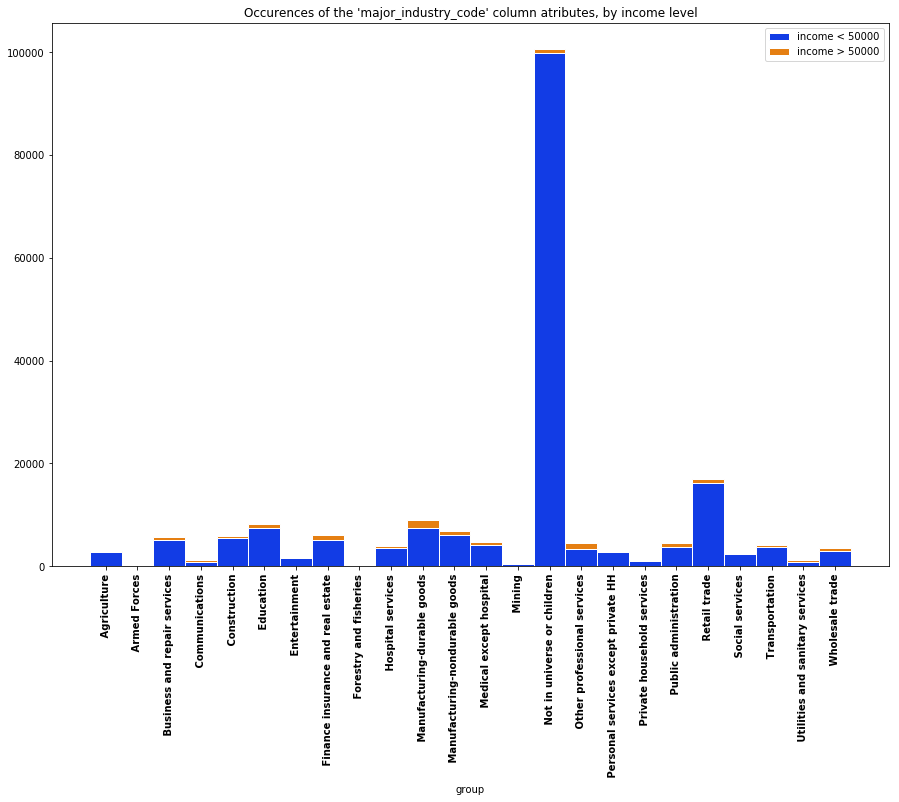



Analysis : 
The attribute "Not in universe" represents 50,46% of the recordings. Most of them are brought by the lower income population: 53.31% of them are concerned while this number is only 7.31% for the higher income population : this is only the fifth attribute of this population (29.01%, 28.06% and 12.30% of them were respectively "Executive admin and managerial", "Professional specialty" and "Sales").

Conclusion : 
People with the higher income are more qualified than others (Which could explain that their earn more money).


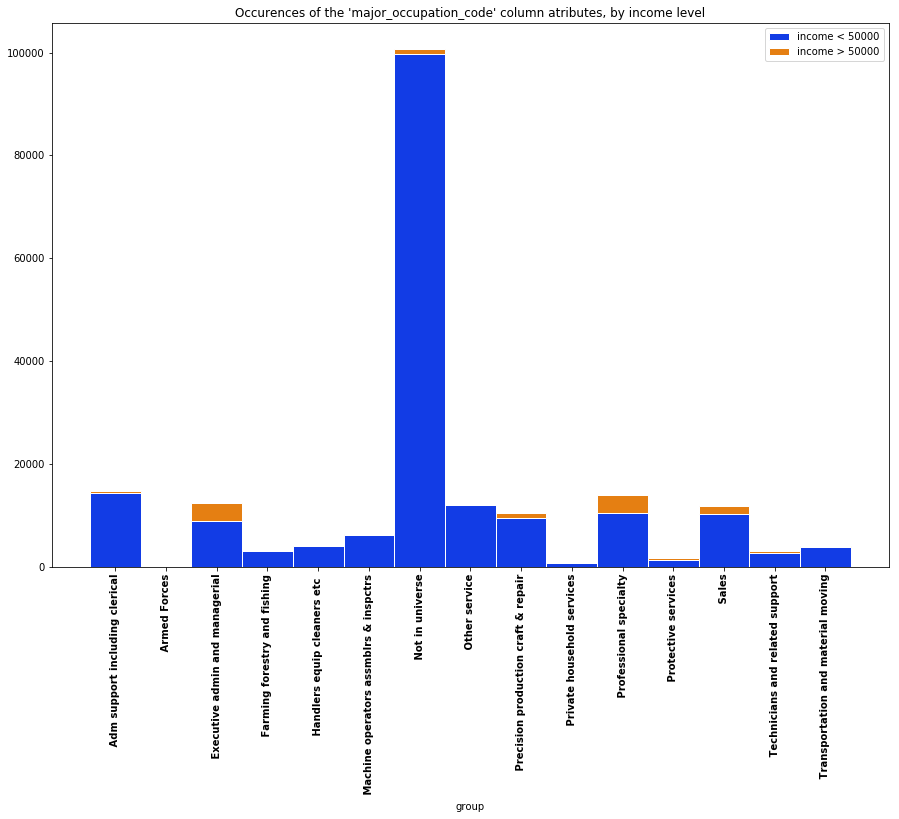



Analysis : 
83.88% of the global population is composed of "White" people. There is a slight difference between lower and higher income populations : White, black and asian people respectively represent 83.40%, 10.62% and 2.88%  of the first population and 91.03%, 4.36% and 3.47% of the second. 

Conclusion : 
Race may have an impact on the income. 


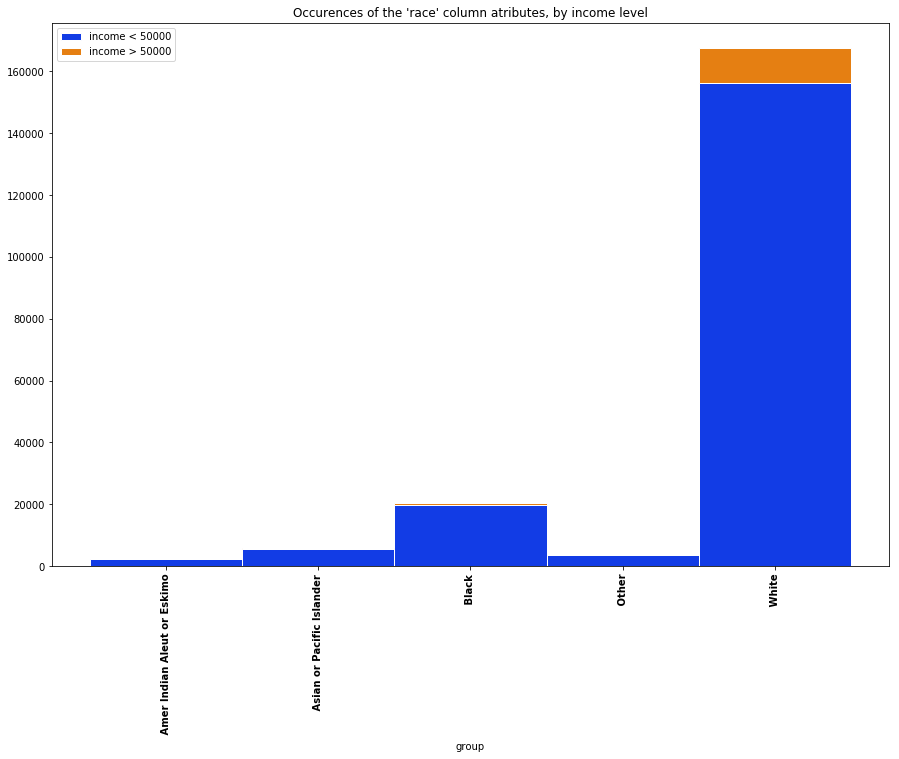


Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since a large majority of peaople is in the category "All other". Furthermore, this column don't seems to bring information that allows to discriminate the two categories.


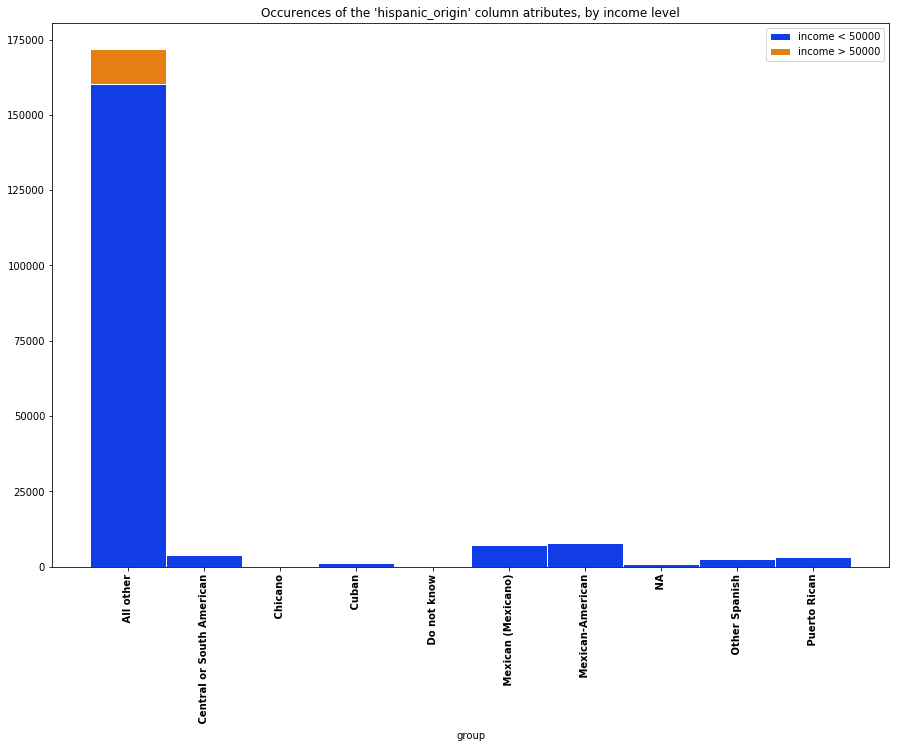



Analysis : 
Females represent 52.11% of the global population. Only 21% of them are in the higher income population while they represent 54.14% of the lower income population.

Conclusion : 
Sex may have an impact on the income. 


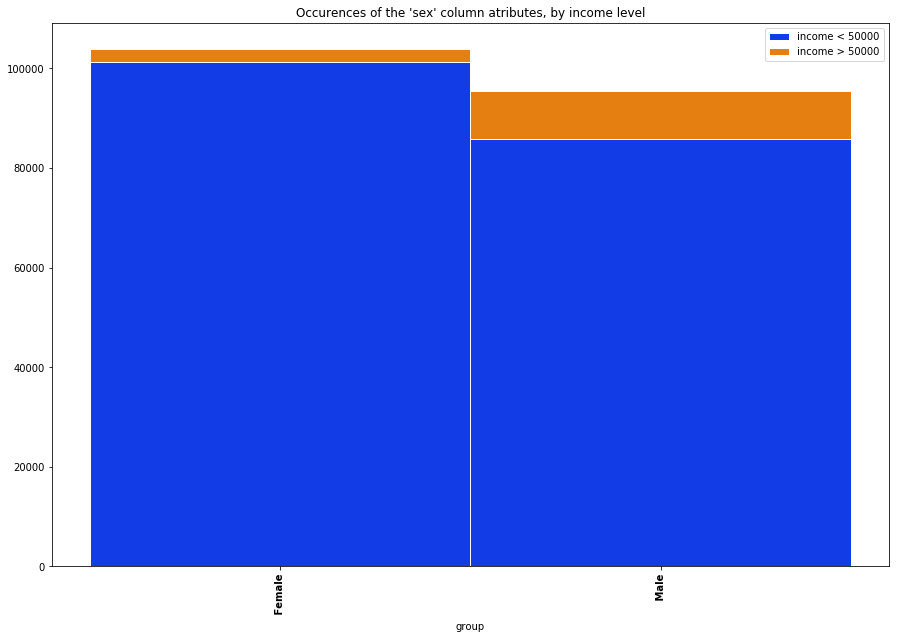



Analysis : 
90.44 of people responded "Not in universe" to this question, which is strange while this is a "yes or no" question. Only 7.59% of the lower income population responded "No" while this number is 14.71% for the higher income population.

Conclusion : 
The "No" affirmation, seems stronger for the higher income population.


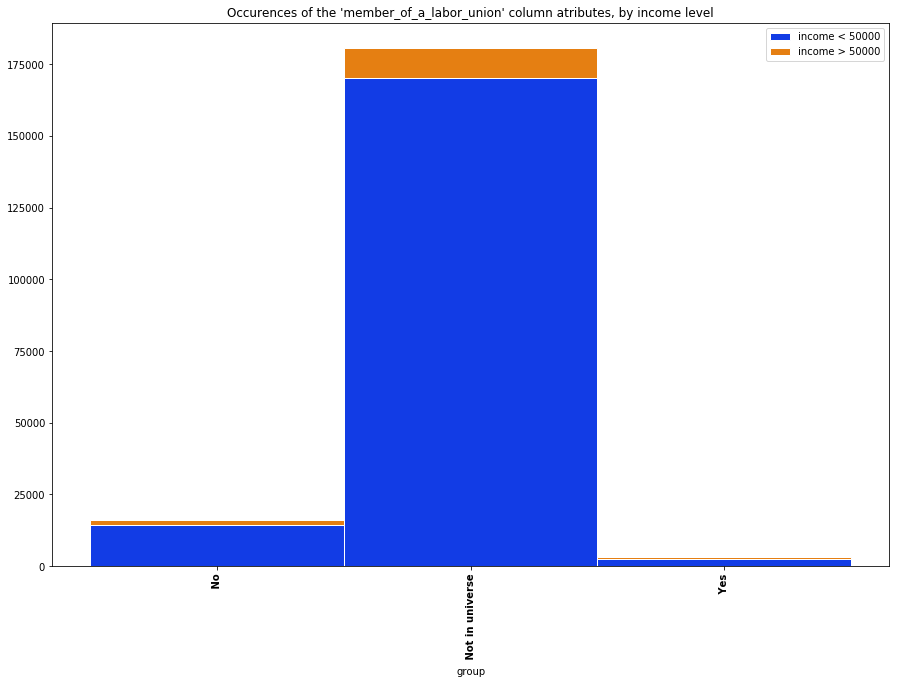

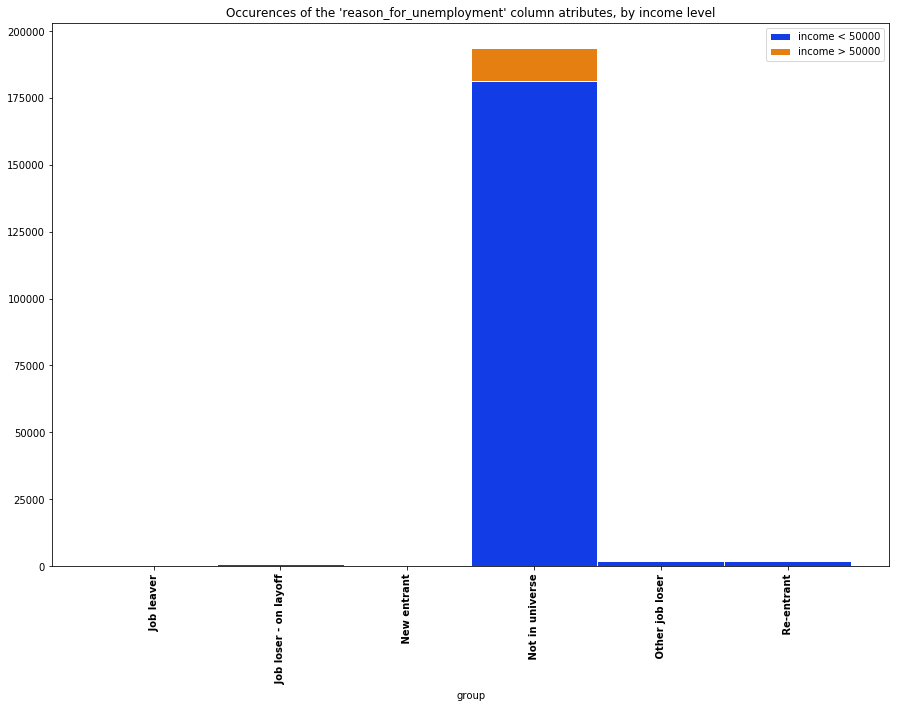

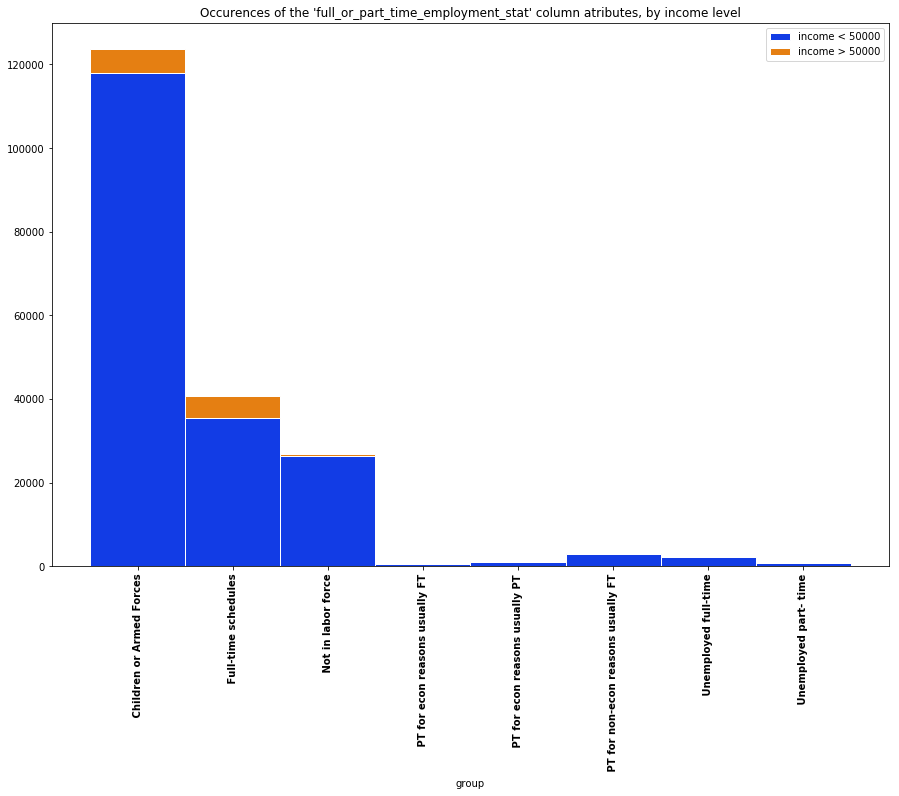



Analysis : 
"Nonfiler" attribute represents 37.63% of the dataset (But only 0,28% of the higher income popultation have it, against 71.49% of the lower income population).


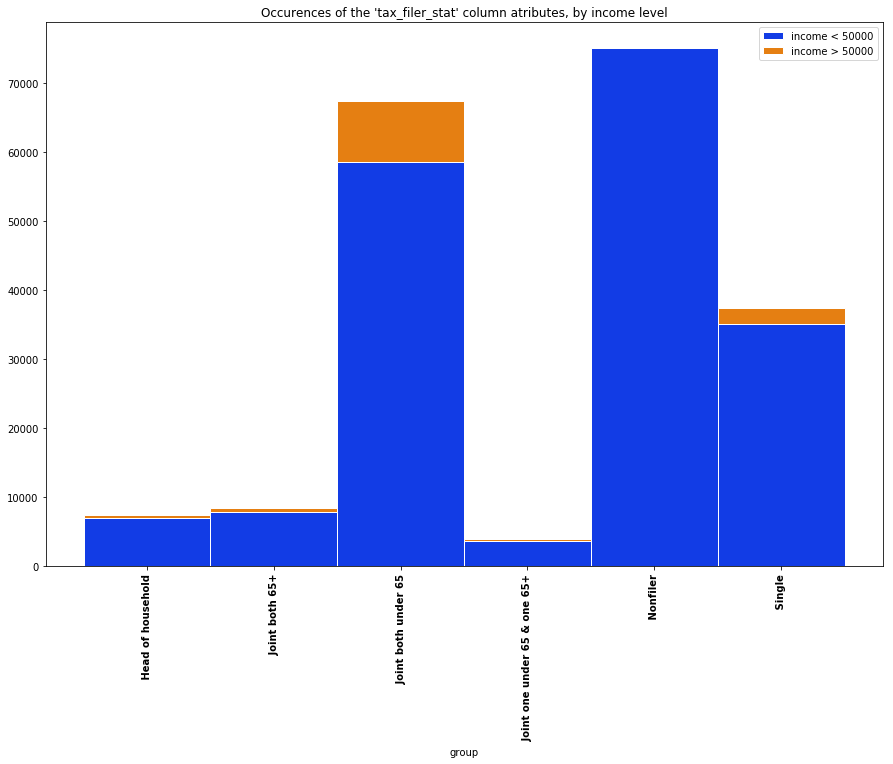

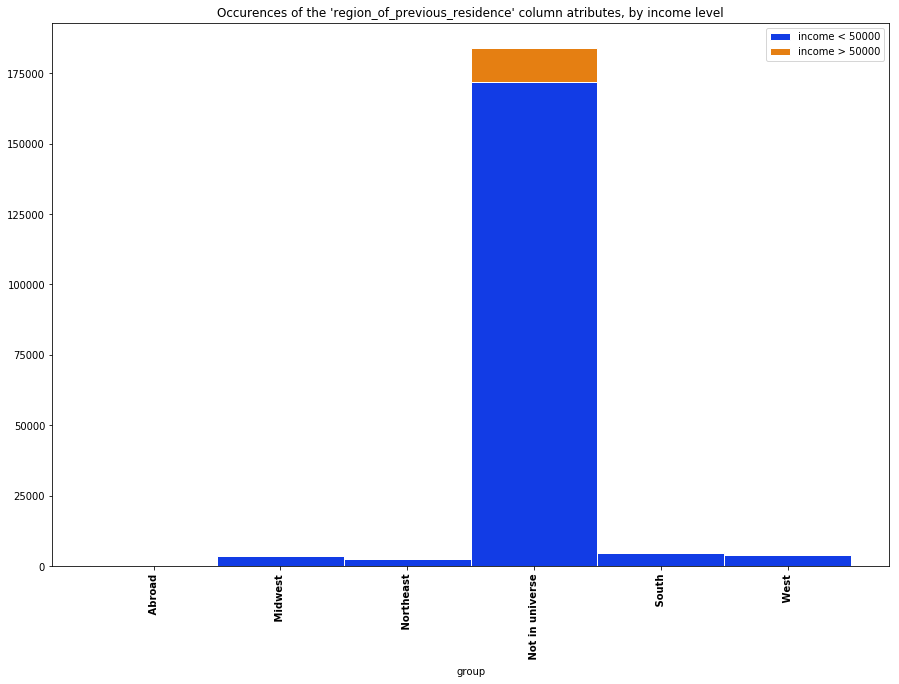


Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since it brings a lot of attributes in the model. Furthermore, a large part of the poulation has the attribute "Not in universe". Finally, it don't seems to bring information that allows to discriminate the two categories since both have majorly this attribute..


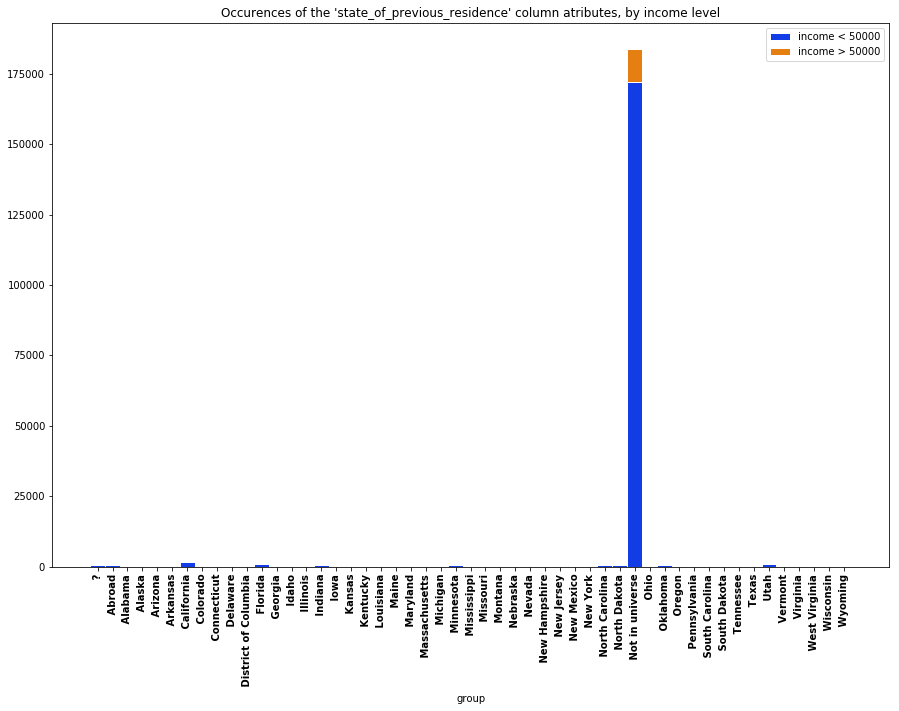



Analysis : 
The "Householder" attribute represents 26.68% of the recordings but 63.39% of the higher income population is a householder, against 26.89% of the lower income population.  Lower income population has mainly (26.89%) the attribute "Child <18 never marr not in subfamily" while "Spouse of householder" and "Nonfamily householder" are the attributes of 18.42% and 14.53% of the higher income population.

Conclusion : 
Higher income population has an easier access to the property.


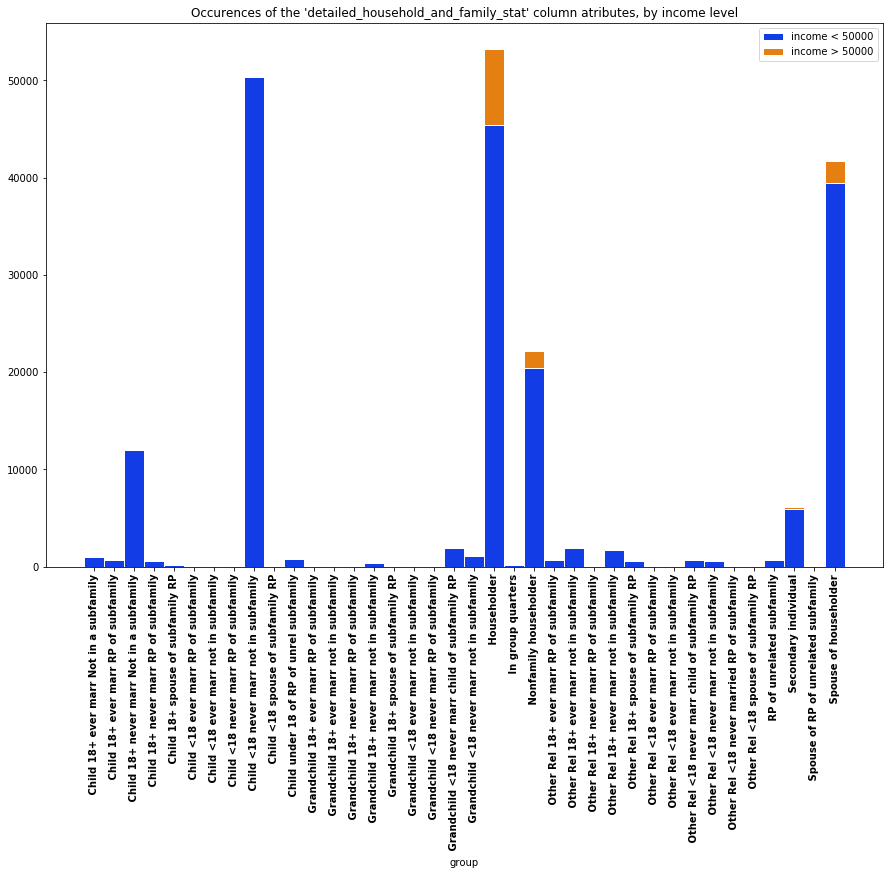



Analysis : 
We can observe the same results as those in the previous analyzis ("detailed_household_and_family_stat") : Lower income population has a reduce access to the property.


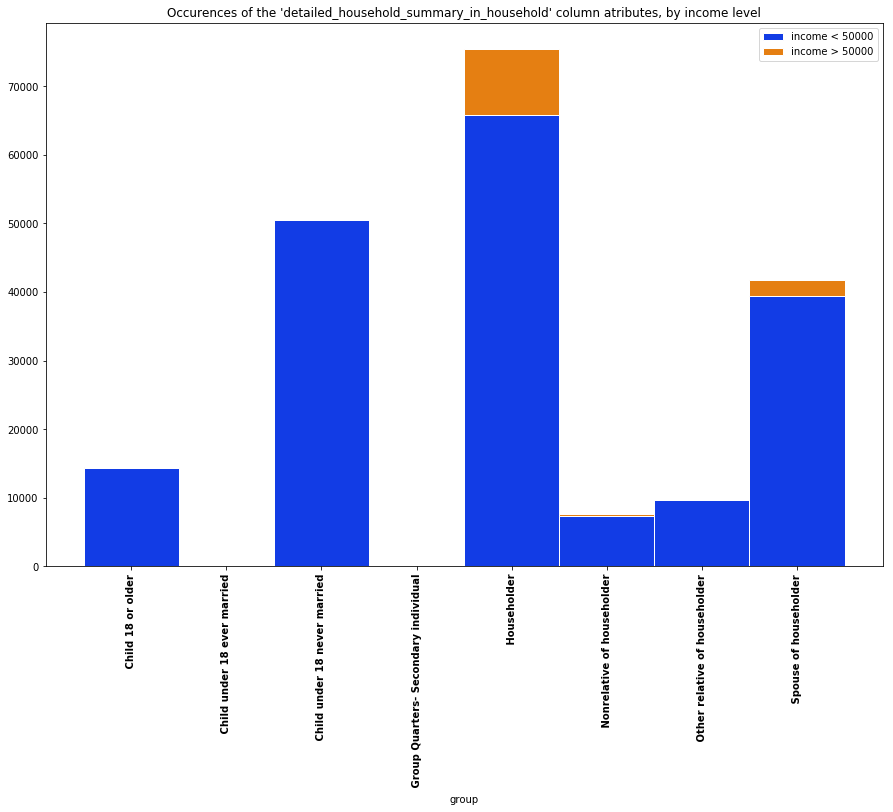

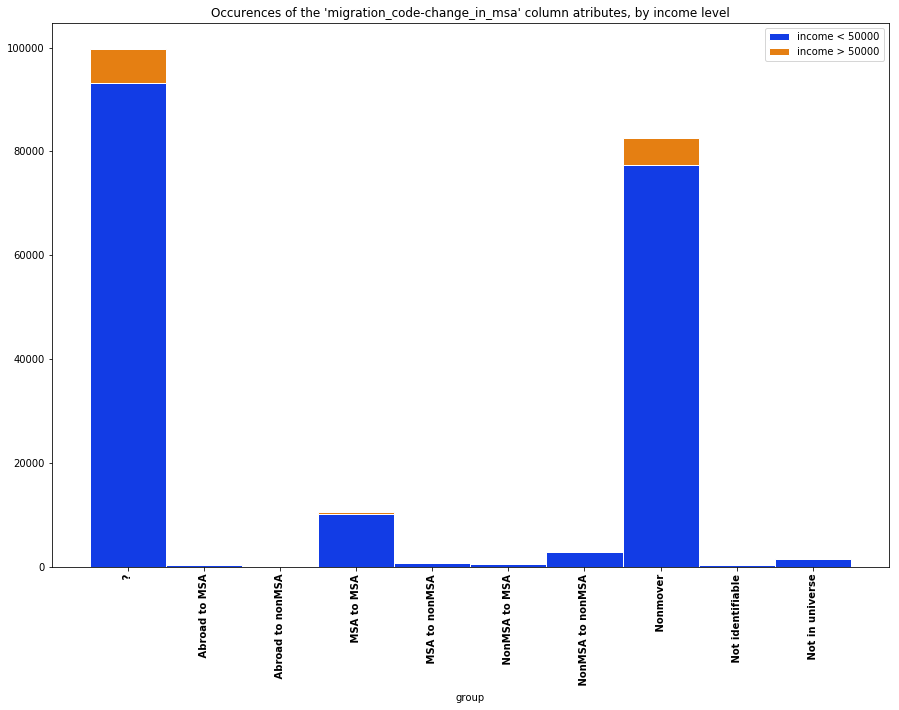

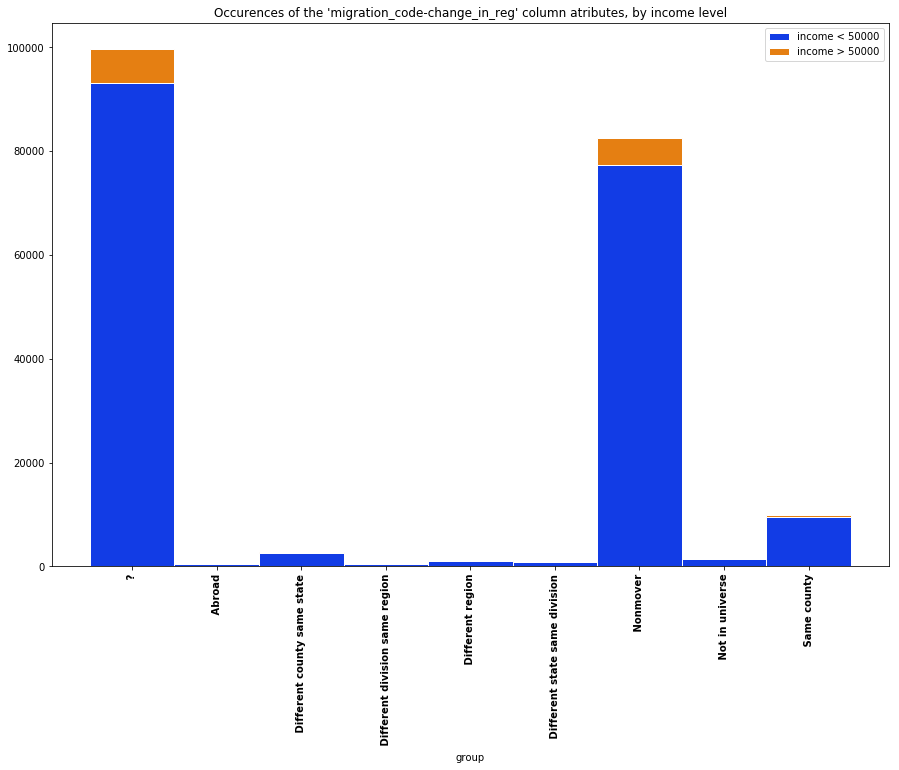

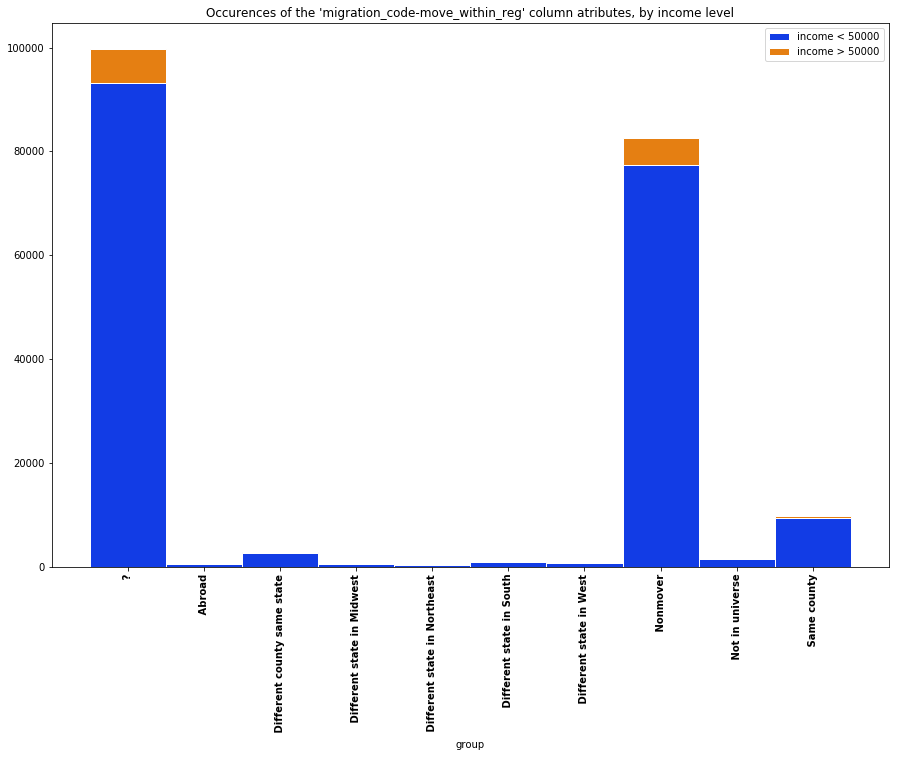



Analysis : 
50.72% of the global population live in it's actual house since less than 1 year. 41.36% since more than 1 year. Percentages are very similar for the two populations.


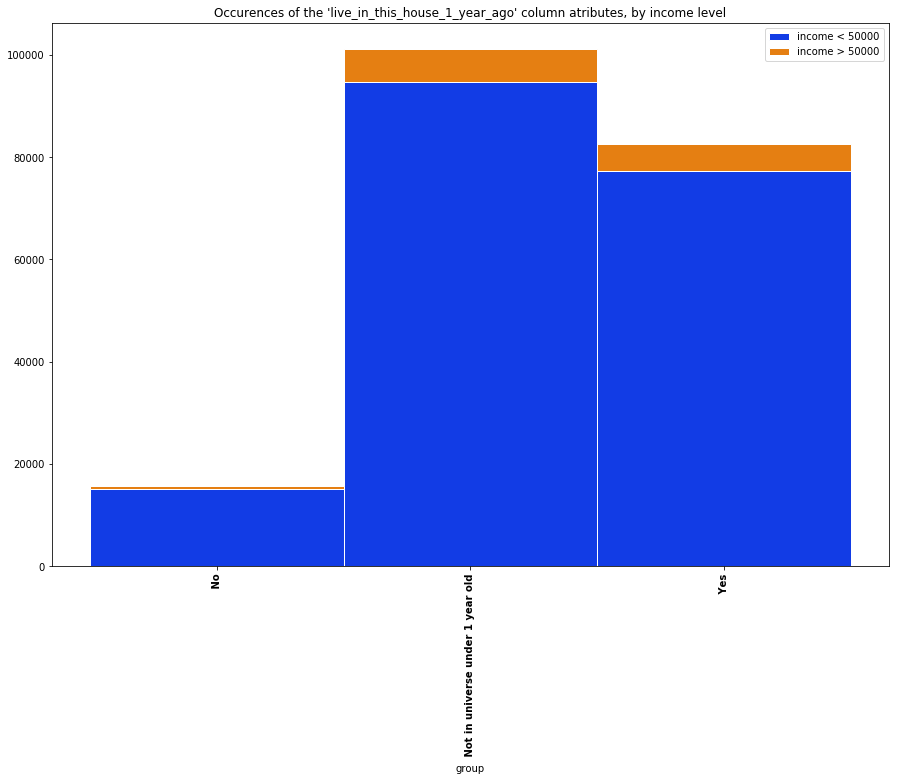

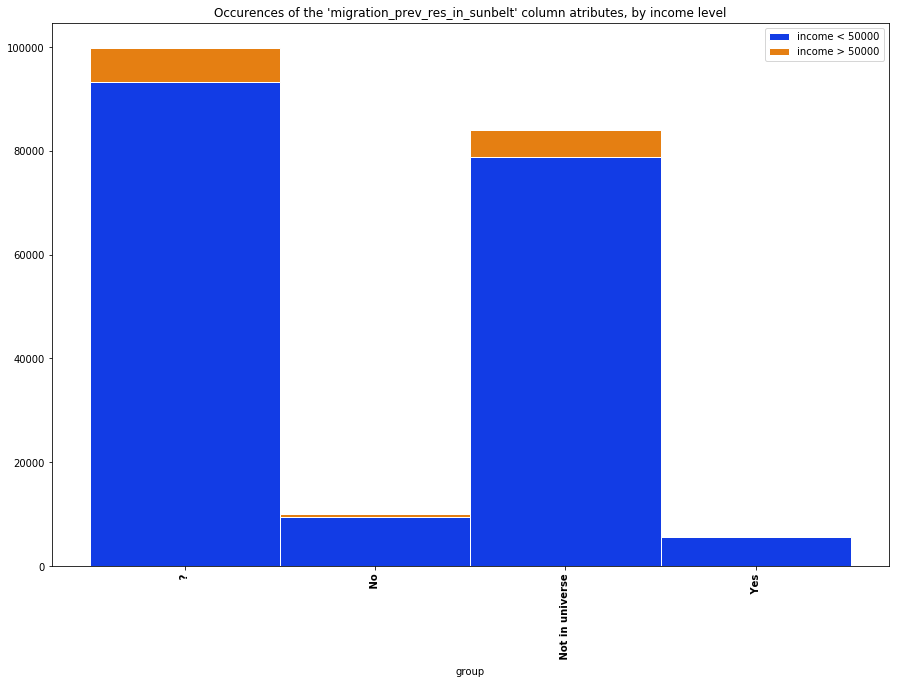

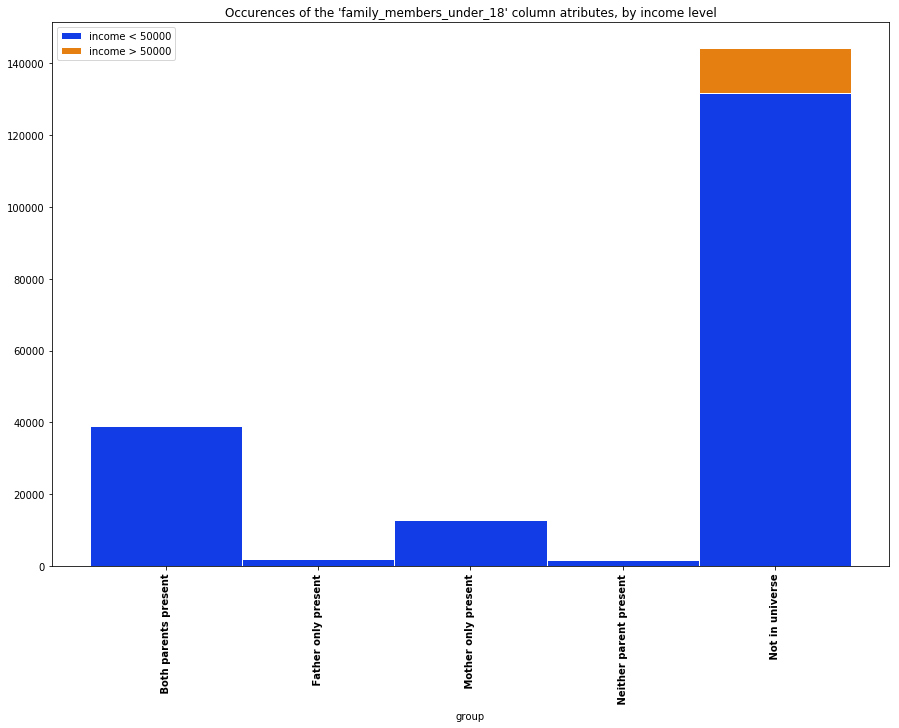



Analysis : 
79.77% of the global population has its father born in the United states. Remaining countries occurencies are distributed over the other categories. Percentages are very close between the twho populations.

Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since it brings a lot of attributes in the model. Furthermore, a huge majority of the poulation has the attribute "United states" for both (high and low ) income categories.


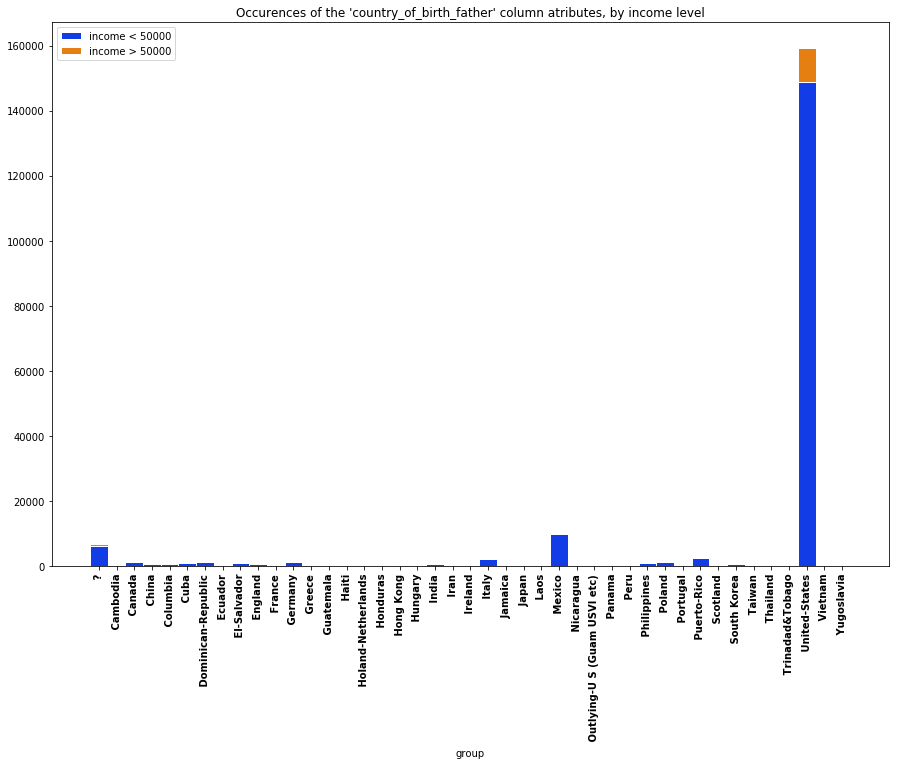



Analysis : 
We can observe results close to those in the previous analyzis ("country_of_birth_father").

Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since it brings a lot of attributes in the model. Furthermore, a huge majority of the poulation has the attribute "United states" for both (high and low ) income categories.


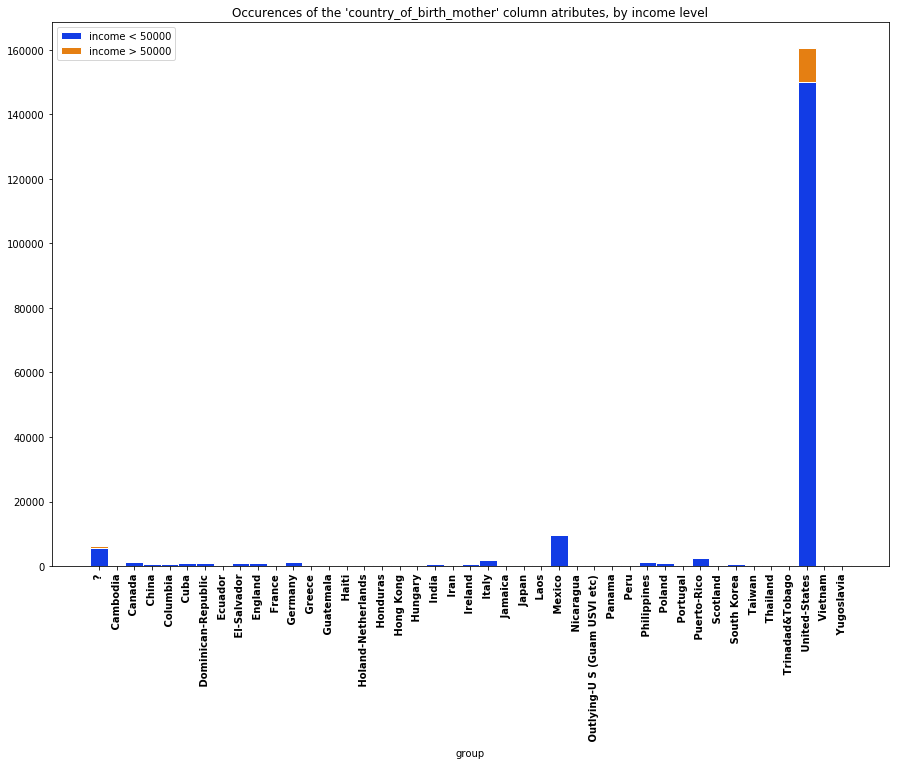



Analysis : 
88.70% of the global population was born in the United States. Percentages of the other attributes are close in the two populations.

Conclusion : 
N.B : For performances needs (models took more than a day to learn) I decided to remove this column, since it brings a lot of attributes in the model. Furthermore, a huge majority of the poulation has the attribute "United states" for both (high and low ) income categories.


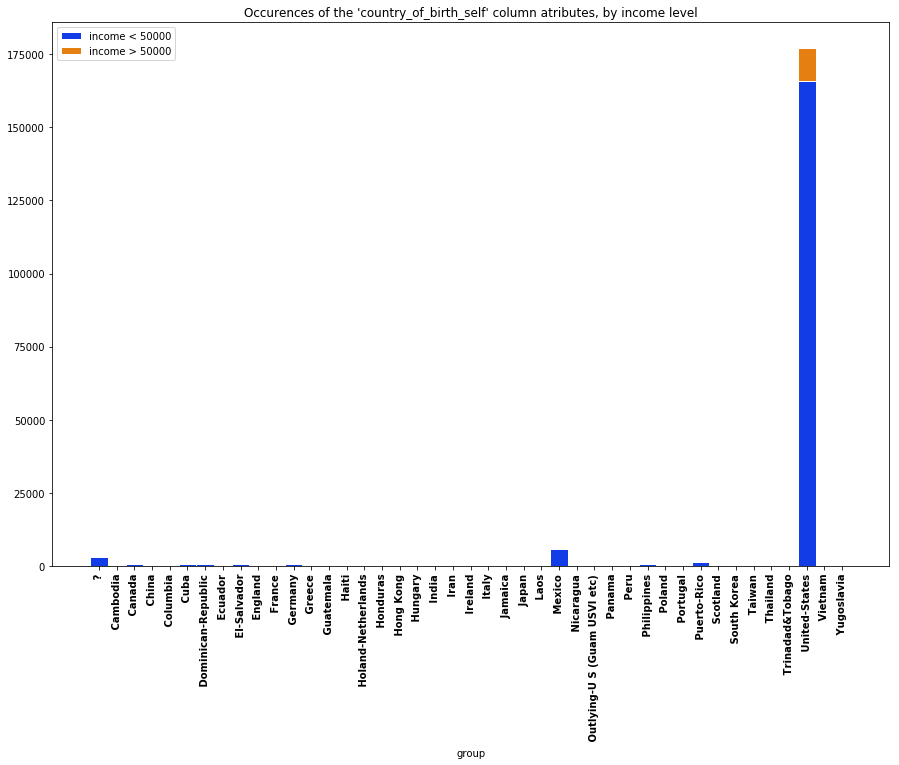



Analysis : 
Without surprise, 88.70% of the global population is composed of native-born americans too. Percentages of the other attributes are close in the two populations.


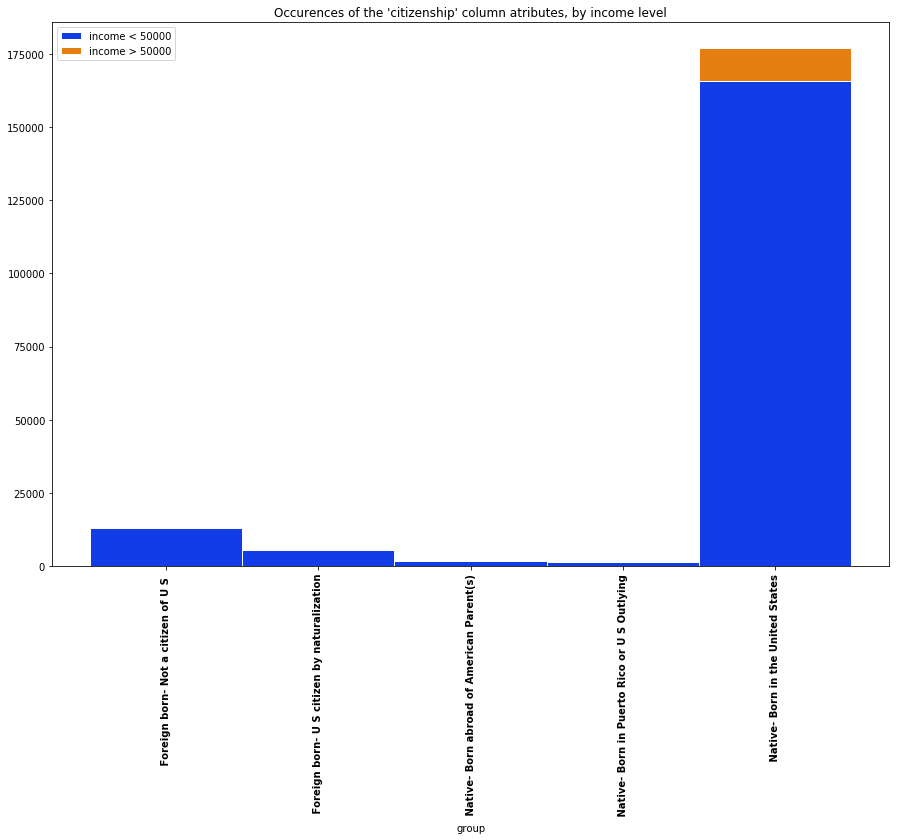



Analysis : 
90.55% of the global population has the code "0" but we can't interpret it since the meaning of this code is not provided by the dataset documentation.


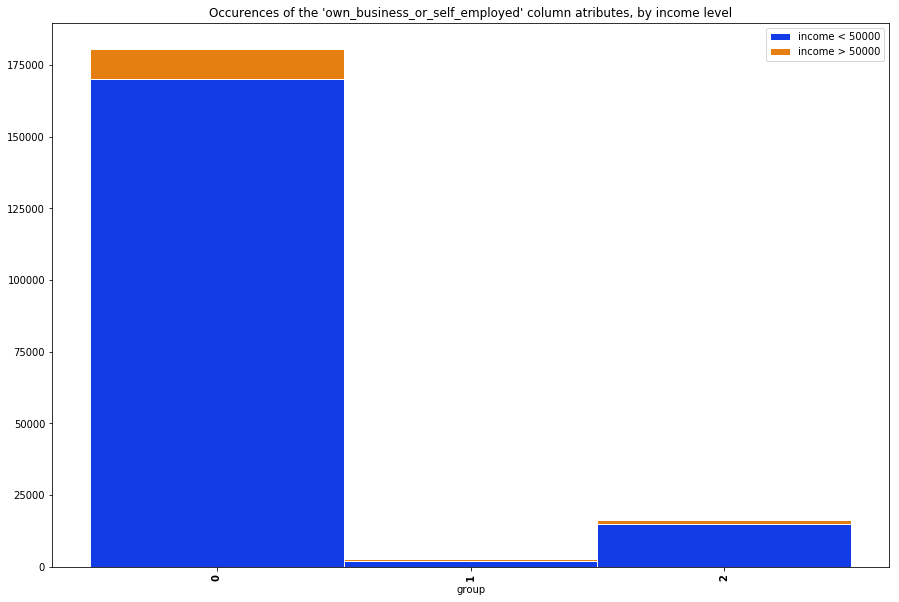

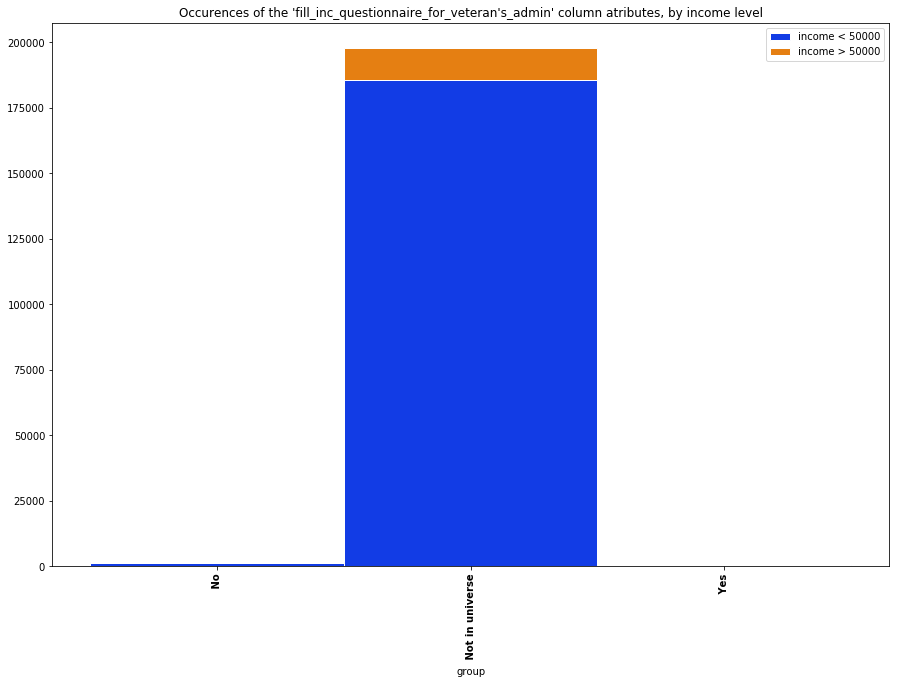



Analysis : 
75.24% of the global population has the code "2" but we can't interpret it since the meaning of this code is not provided by the dataset documentation. This is however interesting to observe that 98.13% of the higher income population has this attribute, against 73.72% in the lower income population members. 25.33% of the lower population members has the code "0".


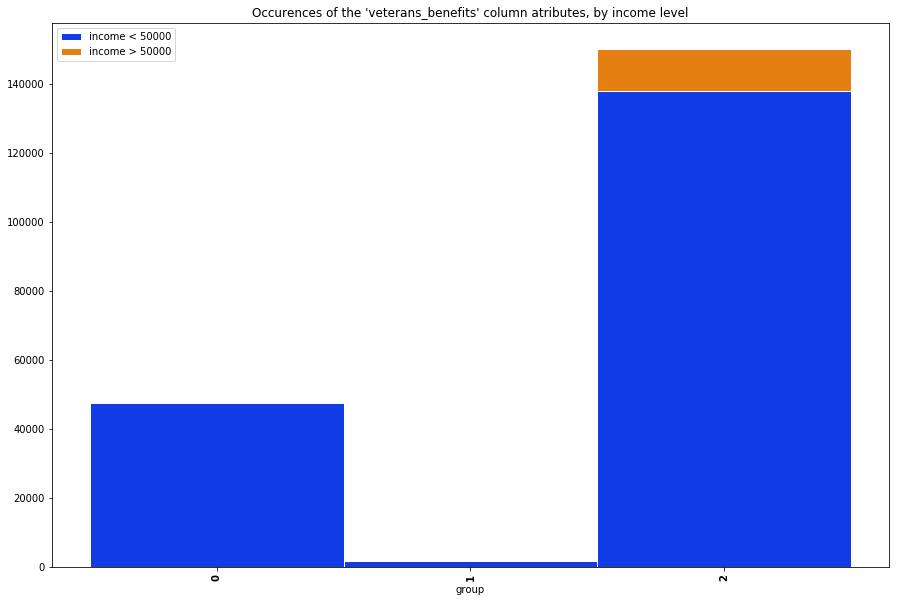

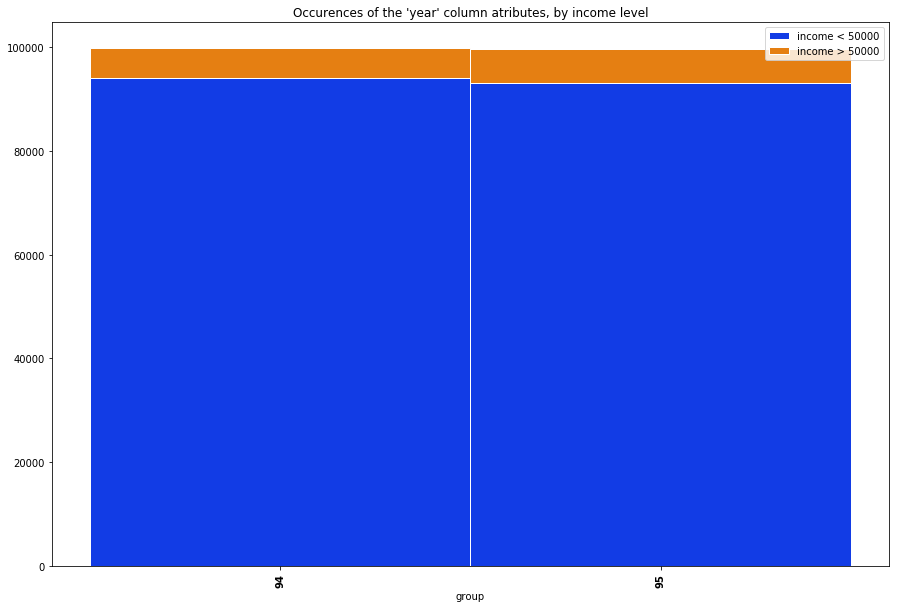

In [29]:
for col in L_categorical_cols:
    df_focus = group_by_income(df_train, col)
        
    analysis = df_graphics_desciptions['analysis'][df_graphics_desciptions['column']==col].values[0]
    if len(analysis)>0:
        print('\n\nAnalysis : \n%s'%analysis)
    conclusion = df_graphics_desciptions['conclusion'][df_graphics_desciptions['column']==col].values[0]
    if len(conclusion)>0:
        print('\nConclusion : \n%s'%conclusion)
            
    title = "Occurences of the '%s' column atributes, by income level"%col
    
    df_low = df_focus[df_focus['income_level']==' - 50000.']
    df_high = df_focus[df_focus['income_level']==' 50000+.']
        
    plt.figure(figsize=(15,10))
    plt.title(title)
    low_bars = list(df_low['occurences'])
        
    high_bars = list(df_high['occurences']) 
    r = list(range(len(df_low[col])))
        
    names = list(df_low[col])
    barWidth = 1

    plt.bar(r, low_bars, color='#123ce5', edgecolor='white', width=barWidth, label='income < 50000')
    plt.bar(r, high_bars, bottom=low_bars, color='#e57f12', edgecolor='white', width=barWidth, label='income > 50000')

    plt.xticks(r, names, fontweight='bold', rotation='vertical')
    plt.xlabel("group")
    plt.legend()

        
    plt.show()

<p>
        **<font color='#D2691E'size="4">III) Categorical columns vectorization</font>**
</p>

In [35]:
L_cols_to_drop = ['detailed_industry_recode',
                  'hispanic_origin',
                  'state_of_previous_residence',
                  'country_of_birth_father',
                  'country_of_birth_mother',
                  'country_of_birth_self']

In [36]:
df_train.drop(L_cols_to_drop, axis=1, inplace=True)
for col in L_cols_to_drop:
    L_categorical_cols.remove(col)

In [37]:
start_time = time.time()
for col in L_categorical_cols:
    df_train[col] = df_train[col].str.lower()
    df_train[col] = df_train[col].str.replace('^ ','')
    df_train[col] = df_train[col].str.replace(' ','_')
    df_train = pd.merge(df_train, pd.get_dummies(df_train[col], prefix=col), how='left', left_index=True, right_index=True)
print("--- %s seconds ---" % (time.time() - start_time))
df_train.drop(L_categorical_cols, axis=1, inplace=True)

--- 12.9693284034729 seconds ---


In [38]:
bamboos.flag_one_step('categorical_columns_vectorization', df_train)
metadata_buffer = bamboos.metadata_buffer
print("Categorical columns vectorization appended %s new columns !"%list(metadata_buffer['n_new_cols'])[0])
metadata_buffer

flagging : categorical_columns_vectorization
Categorical columns vectorization appended 261 new columns !


c:\python\python36\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
3,3,categorical_columns_vectorization,1.0,0.0,199523,269,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],261,"[class_of_worker_federal_government, class_of_...",33,"[class_of_worker, detailed_industry_recode, de..."
0,2,affecting_correct_datatypes,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
1,1,removing_column_ignore,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],1,[ignore]
2,0,init,1.0,0.0,199523,42,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]


In [39]:
#Our metatada buffer shows us a "global_completion_ratio" of 1.0, which means that it don't contains any missing values : 
# => We are sure that we can make more complex transforms like dimension reduction and classification 

<p>
        **<font color='#D2691E'size="4">IV) Separation into target and predictors</font>**
</p>

In [41]:
L_predictors = [col for col in df_train.columns if col!='income_level']

In [42]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['income_level'])
encoded_income = label_encoder.transform(df_train['income_level'])
encoded_income

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
df_train['income_level'] = encoded_income

<p>
        **<font color='#D2691E'size="4">V) Separation into train and test perimeters</font>**
</p>

In [44]:
X = df_train[L_predictors].values

In [45]:
y = df_train['income_level'].values

In [46]:
#We are going to split the data into train and test perimeters.
##Since there is a big difference between the number of the two populations, it's important to "stratify" the split and to verify
#That the two datasets have the same targets divisions.
#That's important in order to have a balanced learning.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [47]:
df_check_train = pd.DataFrame(y_train, columns = ['income_level'])
df_income_level_train = df_check_train[['income_level']].copy()
df_income_level_train['incr'] = 1
df_income_level_train = df_income_level_train[['income_level', 'incr']].groupby('income_level').sum()
df_income_level_train.sort_values(by='incr', ascending=True, inplace=True)
df_income_level_train['percent_of_total'] = df_income_level_train['incr']/np.sum(df_income_level_train['incr'])
df_income_level_train

,incr,percent_of_total
income_level,,
1,9286,0.062055
0,140356,0.937945


In [48]:
df_check_test = pd.DataFrame(y_test, columns = ['income_level'])
df_income_level_test = df_check_test[['income_level']].copy()
df_income_level_test['incr'] = 1
df_income_level_test = df_income_level_test[['income_level', 'incr']].groupby('income_level').sum()
df_income_level_test.sort_values(by='incr', ascending=True, inplace=True)
df_income_level_test['percent_of_total'] = df_income_level_test['incr']/np.sum(df_income_level_test['incr'])
df_income_level_test

,incr,percent_of_total
income_level,,
1,3096,0.062068
0,46785,0.937932


In [49]:
#Both dataframes have the same percentages of each categories
L_classes_weights = [{class_:weight for class_, weight in zip(df_income_level_train.index, df_income_level_train['incr'])}]
L_classes_weights

[{0: 140356, 1: 9286}]

<p>
        **<font color='#D2691E'size="4">VI) Dimension reduction</font>**
</p>

In [50]:
data_scaler = preprocessing.StandardScaler().fit(X_train)

In [51]:
X_scaled_train = data_scaler.transform(X_train)

In [52]:
#Applying standard scaler to test data :
X_scaled_test = data_scaler.transform(X_test)

In [53]:
pca = decomposition.PCA(n_components=X_scaled_train.shape[1])
pca.fit(X_scaled_train)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

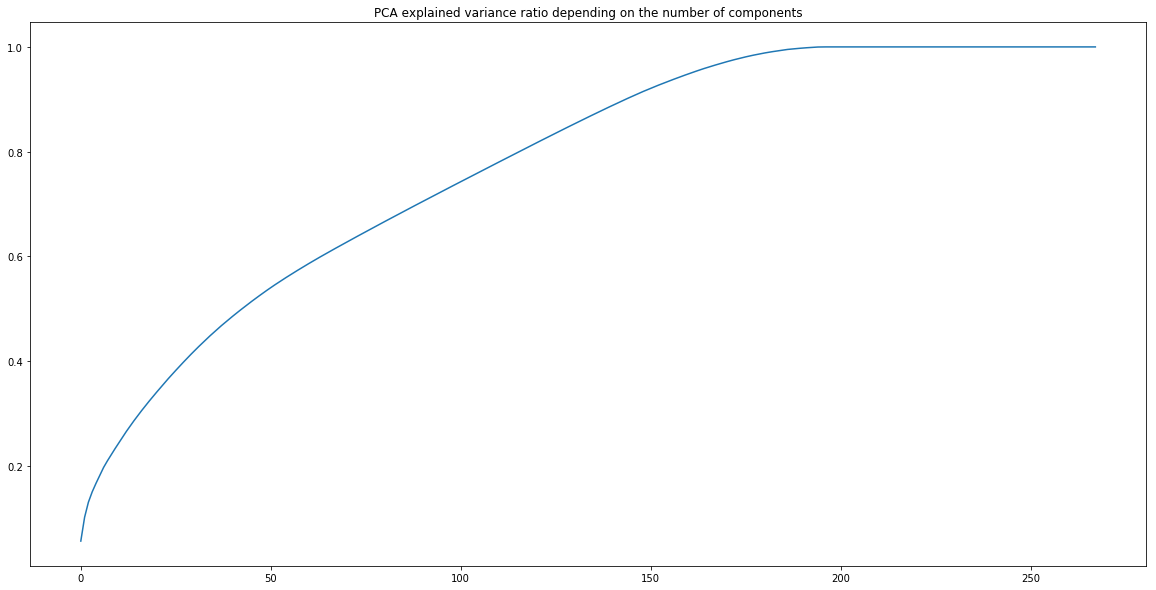

In [54]:
plt.figure(figsize=(20,10))
plt.title("PCA explained variance ratio depending on the number of components")
plt.plot(explained_variance_ratio)

In [55]:
pca = PCA(n_components=150)
pca.fit(X_scaled_train)
print('pca explained variance ratio : %s'%pca.explained_variance_ratio_.sum())
X_PCA_train = pca.transform(X_scaled_train)

pca explained variance ratio : 0.915474867714698


In [56]:
#Applying pca to test data
X_PCA_test = pca.transform(X_scaled_test)

In [57]:
X_train_fin = X_PCA_train
X_test_fin = X_PCA_test

<p>
        **<font color='#D2691E'size="4">VII) Building classifiers with cross validation </font>**
</p>

<p>
        **<font color='#D2691E'size="4">VII.1) Logistic regression</font>**
</p>

<p>
        **<font color='#D2691E'size="4">VII.1.A) Logistic regression : cross validation</font>**
</p>

In [59]:
clf_lr  = model_selection.GridSearchCV(LogisticRegression(),
                                      {'penalty':['l1', 'l2'],
                                       'C':[0.1, 0.5, 1.0]},
                                       cv = 5,
                                       scoring = 'accuracy')

#C : Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify 
#stronger regularization.

In [60]:
#We fit the grid search classifiers :
start_time = time.time()
clf_lr.fit(X_train_fin, y_train)
print("--- %s seconds to fit the clf_lr model---" % (time.time() - start_time))

--- 8719.783385276794 seconds to fit the clf_lr model---


In [61]:
#Bests parameters are : 
best_params_lr= clf_lr.best_params_
print("best_params_clf_lr : %s"%best_params_lr)

best_params_clf_lr : {'C': 1.0, 'penalty': 'l1'}


In [62]:
#Resulting performances with each hyperparameters are : 
for mean, std, params in zip(clf_lr.cv_results_['mean_test_score'],
                            clf_lr.cv_results_['std_test_score'],
                            clf_lr.cv_results_['params']):
    print('logistic regression : \taccuracy = %0.3f (+/-%0.3f) for %s'%(mean,std*2,params))

logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 0.1, 'penalty': 'l1'}
logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 0.1, 'penalty': 'l2'}
logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 0.5, 'penalty': 'l1'}
logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 0.5, 'penalty': 'l2'}
logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 1.0, 'penalty': 'l1'}
logistic regression : 	accuracy = 0.951 (+/-0.001) for {'C': 1.0, 'penalty': 'l2'}


In [63]:
#Logistic regression : applying on the test data

In [64]:
y_pred_lr_test = clf_lr.predict(X_test_fin)
clf_lr_test_accuracy = metrics.accuracy_score(y_test, y_pred_lr_test)
print("Accuracy on test data for clf_lr model is : %s"%clf_lr_test_accuracy)

Accuracy on test data for clf_lr model is : 0.951203865199174


<p>
        **<font color='#D2691E'size="4">VII.1.B) Logistic regression : final model</font>**
</p>

In [65]:
start_time = time.time()
lr_fin = LogisticRegression(penalty=best_params_lr['penalty'],
                                    C=best_params_lr['C'],
                                    n_jobs=4)

lr_fin.fit(X_train_fin, y_train)

c:\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
#Predictions : 
y_pred_lr_fin  = lr_fin.predict(X_test_fin)
accuracy_lr_fin = metrics.accuracy_score(y_test, y_pred_lr_fin)
print("Accuracy on the test perimeter is : %s"%accuracy_lr_fin)

Accuracy on the test perimeter is : 0.951203865199174


<p>
        **<font color='#D2691E'size="4">VII.2) Support vector classifier</font>**
</p>

<p>
        **<font color='#D2691E'size="4">VII.2.A) Support vector classifier : cross validation</font>**
</p>

In [67]:
clf_svc  = model_selection.GridSearchCV(LinearSVC(),
                                      {'C':[0.1, 0.5, 1.0]},
                                       cv = 5,
                                        scoring = 'accuracy')

In [68]:
#We fit the grid search classifiers :
start_time = time.time()
clf_svc.fit(X_train_fin, y_train)
print("--- %s seconds to fit the svc model---" % (time.time() - start_time))

--- 780.2787313461304 seconds to fit the svc model---


In [69]:
#Bests parameters are : 
best_params_svc = clf_svc.best_params_
print("best_params_svc : %s"%best_params_svc)

best_params_svc : {'C': 0.1}


In [70]:
#Resulting performances with each hyperparameters are : 
for mean, std, params in zip(clf_svc.cv_results_['mean_test_score'],
                            clf_svc.cv_results_['std_test_score'],
                            clf_svc.cv_results_['params']):
    print('support vector classifier : \taccuracy = %0.3f (+/-%0.3f) for %s'%(mean,std*2,params))

support vector classifier : 	accuracy = 0.949 (+/-0.001) for {'C': 0.1}
support vector classifier : 	accuracy = 0.949 (+/-0.001) for {'C': 0.5}
support vector classifier : 	accuracy = 0.949 (+/-0.001) for {'C': 1.0}


In [71]:
#support vector classifier : applying on the test data

In [72]:
y_pred_svc_test = clf_svc.predict(X_test_fin)
clf_svc_test_accuracy = metrics.accuracy_score(y_test, y_pred_svc_test)
print("Accuracy on test data for clf_svc model is : %s"%clf_svc_test_accuracy)

Accuracy on test data for clf_svc model is : 0.9502415749483771


<p>
        **<font color='#D2691E'size="4">VII.2.B) Support vector classifier : final model</font>**
</p>

In [73]:
start_time = time.time()
svc_fin = LinearSVC(C = best_params_svc['C'])

svc_fin.fit(X_train_fin, y_train)
print("--- %s seconds to fit the svc model---" % (time.time() - start_time))

--- 50.9766960144043 seconds to fit the svc model---


In [74]:
#Predictions : 
y_pred_svc_fin  = svc_fin.predict(X_test_fin)
accuracy_svc_fin = metrics.accuracy_score(y_test, y_pred_svc_fin )
print("Accuracy on the test perimeter is : %s"%accuracy_svc_fin)

Accuracy on the test perimeter is : 0.9502014795212606


<p>
        **<font color='#D2691E'size="4">VII.3) Random forest</font>**
</p>

<p>
        **<font color='#D2691E'size="4">VII.3.A) Random forest : cross validation</font>**
</p>

In [75]:
clf_rf  = model_selection.GridSearchCV(RandomForestClassifier(),
                                      {'n_estimators':[100, 500, 1000, 2000],
                                       'max_features':[2,5,10]},
                                      cv = 5,
                                      scoring = 'accuracy')

In [76]:
#We fit the grid search classifiers :
start_time = time.time()
clf_rf.fit(X_train_fin, y_train)
print("--- %s seconds to fit the rf model---" % (time.time() - start_time))

--- 45529.6804227829 seconds to fit the rf model---


In [77]:
#Bests parameters are : 
best_params_rf = clf_rf.best_params_
print("best_params_rf : %s"%best_params_rf)

best_params_rf : {'max_features': 10, 'n_estimators': 1000}


In [78]:
#Resulting performances with each hyperparameters are : 
for mean, std, params in zip(clf_rf.cv_results_['mean_test_score'],
                            clf_rf.cv_results_['std_test_score'],
                            clf_rf.cv_results_['params']):
    print('random forest classifier : \taccuracy = %0.3f (+/-%0.3f) for %s'%(mean,std*2,params))

random forest classifier : 	accuracy = 0.944 (+/-0.001) for {'max_features': 2, 'n_estimators': 100}
random forest classifier : 	accuracy = 0.944 (+/-0.001) for {'max_features': 2, 'n_estimators': 500}
random forest classifier : 	accuracy = 0.944 (+/-0.001) for {'max_features': 2, 'n_estimators': 1000}
random forest classifier : 	accuracy = 0.944 (+/-0.001) for {'max_features': 2, 'n_estimators': 2000}
random forest classifier : 	accuracy = 0.945 (+/-0.001) for {'max_features': 5, 'n_estimators': 100}
random forest classifier : 	accuracy = 0.945 (+/-0.000) for {'max_features': 5, 'n_estimators': 500}
random forest classifier : 	accuracy = 0.946 (+/-0.001) for {'max_features': 5, 'n_estimators': 1000}
random forest classifier : 	accuracy = 0.946 (+/-0.001) for {'max_features': 5, 'n_estimators': 2000}
random forest classifier : 	accuracy = 0.946 (+/-0.001) for {'max_features': 10, 'n_estimators': 100}
random forest classifier : 	accuracy = 0.946 (+/-0.000) for {'max_features': 10, 'n_es

In [79]:
#Random forest classifier : applying on the test data

In [80]:
y_pred_rf_test = clf_lr.predict(X_test_fin)
clf_rf_test_accuracy = metrics.accuracy_score(y_test, y_pred_rf_test)
print("Accuracy on test data for clf_rf model is : %s"%clf_rf_test_accuracy)

Accuracy on test data for clf_rf model is : 0.951203865199174


<p>
        **<font color='#D2691E'size="4">VII.3.B) Random forest : final model</font>**
</p>

In [81]:
start_time = time.time()
rf_fin = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'],
                                         max_features=best_params_rf['max_features'])

rf_fin.fit(X_train_fin, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1805.5124173164368 seconds ---


In [82]:
#Predictions : 
y_pred_rf_fin  = rf_fin.predict(X_test_fin) 
accuracy_rf_fin = metrics.accuracy_score(y_test, y_pred_rf_fin)
print("Accuracy on the test perimeter is : %s"%accuracy_svc_fin)

Accuracy on the test perimeter is : 0.9502014795212606


<p>
        **<font color='#D2691E'size="4">VIII) Benchmark of the classifier performances </font>**
</p>

In [83]:
df_accuracies = pd.DataFrame(y_test, columns=['y_test'])
df_accuracies['y_pred_lr_fin'] = y_pred_lr_fin
df_accuracies['y_pred_svc_fin'] = y_pred_svc_fin
df_accuracies['y_pred_rf_fin'] = y_pred_rf_fin
df_accuracies['lr_acc'] = 0
df_accuracies['svc_acc'] = 0
df_accuracies['rf_acc'] = 0

df_accuracies['lr_acc'][df_accuracies['y_test']==df_accuracies['y_pred_lr_fin']] = 1
df_accuracies['svc_acc'][df_accuracies['y_test']==df_accuracies['y_pred_svc_fin']] = 1
df_accuracies['rf_acc'][df_accuracies['y_test']==df_accuracies['y_pred_rf_fin']] = 1
df_accuracies.head()

,y_test,y_pred_lr_fin,y_pred_svc_fin,y_pred_rf_fin,lr_acc,svc_acc,rf_acc
0,0,0,0,0,1,1,1
1,0,0,0,0,1,1,1
2,0,0,0,0,1,1,1
3,0,0,0,0,1,1,1
4,0,0,0,0,1,1,1


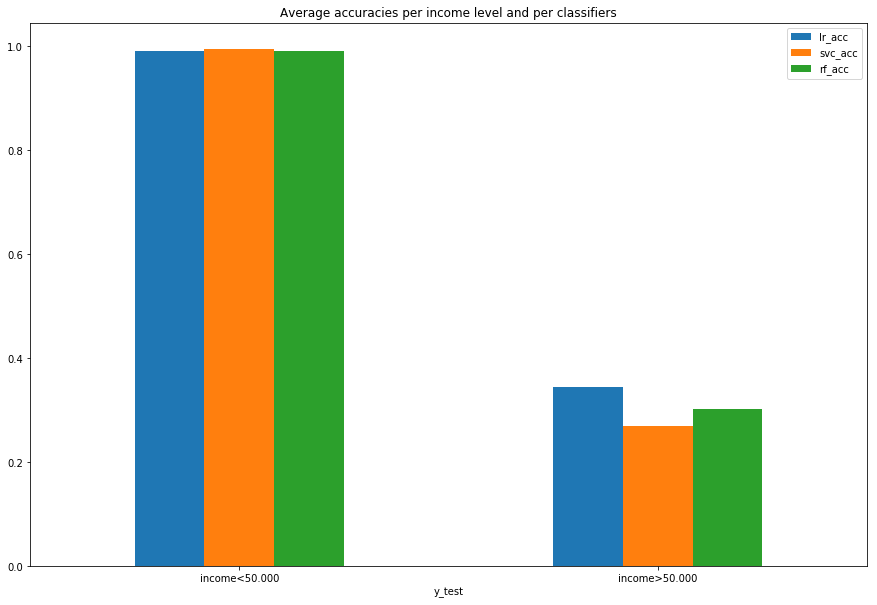

In [84]:
df_accuracies['y_test'] = df_accuracies['y_test'].astype(str)
df_accuracies['y_test'] = df_accuracies['y_test'].str.replace('0','income<50.000')
df_accuracies['y_test'] = df_accuracies['y_test'].str.replace('1','income>50.000')
grouped = df_accuracies[['y_test', 'lr_acc', 'svc_acc', 'rf_acc']].groupby('y_test').mean()
title = "Average accuracies per income level and per classifiers"
grouped.plot.bar(figsize=(15,10), title=title, rot=0)

<p>
    The logistic regression is the algorithm which captures the best the higher income category: thatswhy I chosen to implement it on the final code (Notebook "Income_final_model").
    However it's accuracy on this category is only around 34% : maybe we could perform a little bit this accuracy by slightly increasing the number of components of the PCA (which only explained 91.5% or the variance ratio).
</p>

<p>
    We could also :
</p>
<p>
    - 1: Try to improve the feature engineering part around the numerical columns (for example discretising it and/or managing its ouliers (but this part is not sensitive since a large part of their data is composed of outliers)).
</p>
<p>
    - 2: Try other classification algorithms.
</p>

In [85]:
grouped

,lr_acc,svc_acc,rf_acc
y_test,,,
income<50.000,0.991386,0.995234,0.990061
income>50.000,0.343992,0.269703,0.301680


In [86]:
metadata_buffer

,step_id,step_label,global_completion_ratio,incomplete_cols_ratio,n_rows,n_cols,cols,n_incomplete_cols,incomplete_cols,n_new_cols,new_cols,n_deleted_cols,deleted_cols
3,3,categorical_columns_vectorization,1.0,0.0,199523,269,"[age, wage_per_hour, capital_gains, capital_lo...",0,[],261,"[class_of_worker_federal_government, class_of_...",33,"[class_of_worker, detailed_industry_recode, de..."
0,2,affecting_correct_datatypes,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
1,1,removing_column_ignore,1.0,0.0,199523,41,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],1,[ignore]
2,0,init,1.0,0.0,199523,42,"[age, class_of_worker, detailed_industry_recod...",0,[],0,[],0,[]
